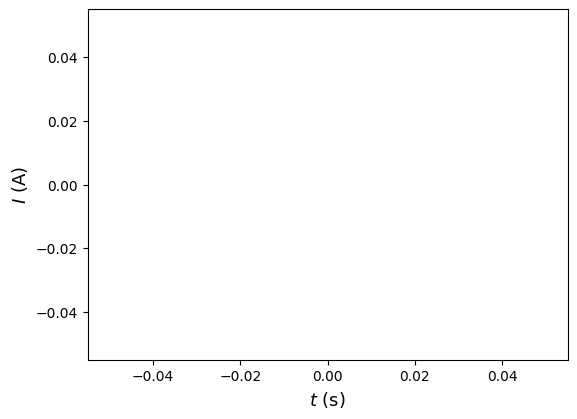

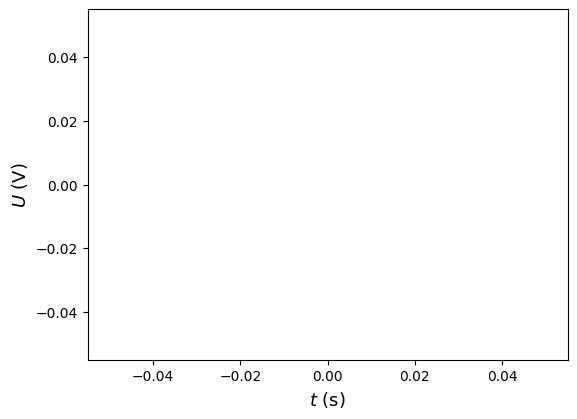

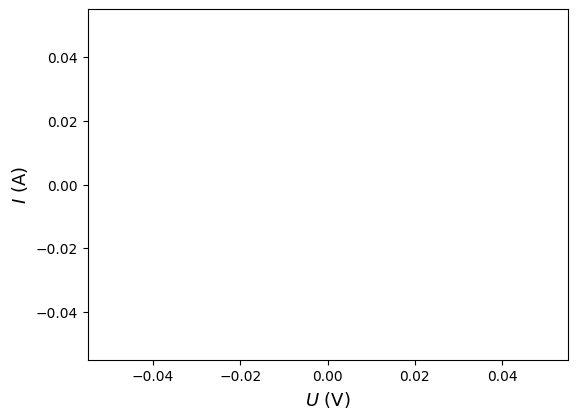

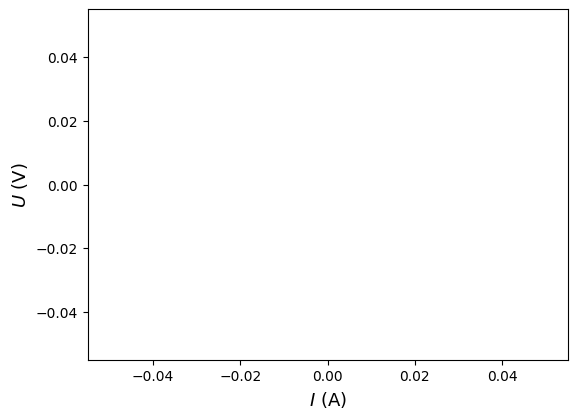

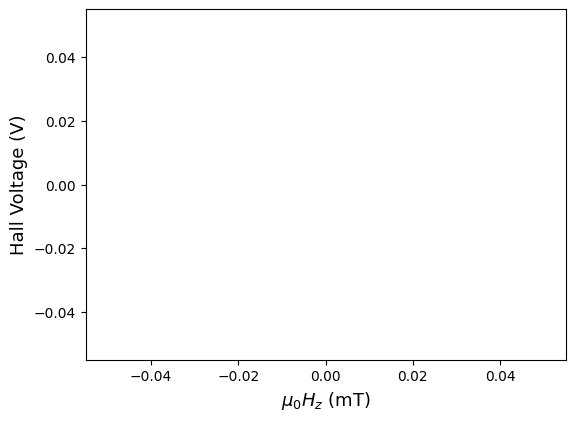

In [26]:
# --------------------------------------- LIBRARIES -------------------------------------------

import tkinter as tk
from tkinter import font as tkFont
from tkinter import ttk, filedialog, messagebox
from tkinter import NO

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import math

import time as tm
import datetime
import json
import os
import sys
import pyautogui
import pyperclip
import threading
import keyboard
import pygetwindow as gw
import ctypes # for icon

import pyvisa
from pymeasure.instruments.keithley import Keithley2400


# ----------------------------------- GLOBAL VARIABLES ----------------------------------------


keithley = None
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.15, bottom=0.15)
line, = ax.plot([], [], 'bo-')
ax.set_xlabel('$t$ (s)', fontsize=13)
ax.set_ylabel('$I$ (A)', fontsize=13)

fig_current, ax_current = plt.subplots()
fig_current.subplots_adjust(left=0.15, bottom=0.15)
line_current, = ax_current.plot([], [], 'bo-')
ax_current.set_xlabel('$t$ (s)', fontsize=13)
ax_current.set_ylabel('$U$ (V)', fontsize=13)

fig_IV, ax_IV = plt.subplots()
fig_IV.subplots_adjust(left=0.15, bottom=0.15)
line_IV, = ax_IV.plot([], [], 'bo-')
ax_IV.set_xlabel('$U$ (V)', fontsize=13)
ax_IV.set_ylabel('$I$ (A)', fontsize=13)

fig_VI, ax_VI = plt.subplots()
fig_VI.subplots_adjust(left=0.15, bottom=0.15)
line_VI, = ax_VI.plot([], [], 'bo-')
ax_VI.set_xlabel('$I$ (A)', fontsize=13)
ax_VI.set_ylabel('$U$ (V)', fontsize=13)

fig_hall, ax_hall = plt.subplots()
fig_hall.subplots_adjust(left=0.15, bottom=0.15)
line_hall, = ax_hall.plot([], [], 'bo-')
ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)

# measurement status
measurement_active = False
measurement_completed = False

# tracking the m. field in the Kerr microscope
magnetic_fields = []
button_x = 0
button_y = 0
field_x = 0
field_y = 0
stop_tracking = False

# remembering the plot
measurement_data = {}
measurement_data_current = {}
measurement_data_IV = {}
measurement_data_VI = {}
measurement_data_hall = {}

# data storage
times_data, currents_data, voltages_data = [], [], []
times_data_current, currents_data_current, voltages_data_current = [], [], []
times_data_IV, currents_data_IV, voltages_data_IV = [], [], []
times_data_VI, currents_data_VI, voltages_data_VI = [], [], []
times_data_hall, currents_data_hall, voltages_data_hall = [], [], []
cycle_nb = 0 # number of cycle in the pulse mode

# store the last used sample and file path
config_file = 'last_session.json'

# lock file
lockfile = "app.lock"

In [27]:
# --------------------------------------- FUNCTIONS -------------------------------------------

# Different sets of functions that are mostly dedicated to: loading sessions, saving sessions,
# storing errors, checking if the program is not running multiple times (Keithley error).


def load_last_session(): # loading last session, i.e., sample name, file path
    if os.path.exists(config_file):
        with open(config_file, 'r') as file:
            config = json.load(file)

            # DC mode
            sample_name.set(config.get('sample_name', ''))
            file_path.set(config.get('file_path', ''))

            # Current mode
            sample_name_current.set(config.get('sample_name', ''))
            file_path_current.set(config.get('file_path', ''))

            # IV mode
            sample_name_IV.set(config.get('sample_name', ''))
            file_path_IV.set(config.get('file_path', ''))

            # VI mode
            sample_name_VI.set(config.get('sample_name', ''))
            file_path_VI.set(config.get('file_path', ''))

            # Hall mode
            sample_name_hall.set(config.get('sample_name', ''))
            file_path_hall.set(config.get('file_path', ''))
            print(f"Loaded session: sample_name={sample_name.get()}, file_path={file_path.get()}")  # debugging
    else:
        print("No previous session found.")  # debugging


def save_last_session(): # saving - based on current tab
    current_tab = tab_control.select()
    if current_tab == tab_control.tabs()[0]:  # DC mode
        sample = sample_name.get()
        path = file_path.get()
        #mode = 'DC' - to do wywalenia? 
    elif current_tab == tab_control.tabs()[1]:  # current mode
        sample = sample_name_current.get()
        path = file_path_current.get()
        #mode = 'current'   
    elif current_tab == tab_control.tabs()[2]:  # IV curve mode
        sample = sample_name_IV.get()
        path = file_path_IV.get()
        #mode = 'IV'
    elif current_tab == tab_control.tabs()[3]:
        sample = sample_name_VI.get()
        path = file_path_VI.get()
        #mode = 'VI'
    else:  # Hall mode
        sample = sample_name_hall.get()
        path = file_path_hall.get()
        #mode = 'Hall'

    config = {
        'sample_name': sample,
        'file_path': path
    }
    print(f"Saving session: {config}")  # debugging
    with open(config_file, 'w') as file:
        json.dump(config, file)


def select_file_path():
    selected_path = filedialog.askdirectory()
    if selected_path:
        # update all file path variables
        file_path.set(selected_path)
        file_path_current.set(selected_path) # bug - zmieniam z fle_path_current(selected_path) na file_path_current.set(selected_path)
        file_path_IV.set(selected_path)
        file_path_VI.set(selected_path)
        file_path_hall.set(selected_path)


def store_errors(error_message): # creates error log file in .txt
    timestamp = datetime.datetime.now().strftime("%d/%m/%y %H:%M")
    error_log = f"The following error has occured ({timestamp}): \n{error_message}\n"

    with open("error_log.txt", "a") as f:
        f.write(error_log)


def is_already_running(): # prevent running the software multiple times
    return os.path.exists(lockfile)


def create_lockfile():
    with open(lockfile, "w") as file:
        file.write("lock")


def remove_lockfile():
    if os.path.exists(lockfile):
        os.remove(lockfile)


def show_error_and_exit(message):
    messagebox.showerror("Error", message)
    sys.exit()


if is_already_running():
    root = tk.Tk()
    root.withdraw()
    show_error_and_exit("Software already running.")
else:
    create_lockfile()


def prevent_column_resize(event): # prevent table columns from stretching
    if event.widget.identify_region(event.x, event.y) == 'separator':
        return 'break'    


def on_closing(): # pop-up window on closing
    popup = tk.Toplevel(root)
    popup.title("Reminder")

    # calculate center position relative to the size of the software
    root_x = root.winfo_x()
    root_y = root.winfo_y()
    root_width = root.winfo_width()
    root_height = root.winfo_height()

    popup_width = 300
    popup_height = 90
    pos_x = root_x + (root_width // 2) - (popup_width // 2)
    pos_y = root_y + (root_height // 2) - (popup_height // 2)
    
    popup.geometry(f"{popup_width}x{popup_height}+{pos_x}+{pos_y}")

    label = ttk.Label(popup, text="Please remember to turn off the Keithley.", wraplength=250)
    label.pack(pady=10)

    ok_button = ttk.Button(popup, text="OK", command=lambda: [save_last_session(), root.destroy()])
    ok_button.pack(pady=5)

    popup.transient(root)
    popup.grab_set()
    root.wait_window(popup)

    remove_lockfile()


# ------------------------------------ KERR FUNCTIONS -----------------------------------------

# This set of functions is used to track and apply a magnetic field to the sample by using the 
# software provided with the Kerr looper (Hysteresis Looper +  Kerr microscope).


def get_current_value(x, y, mode):
    pyautogui.moveTo(x, y)
    pyautogui.doubleClick()
    pyautogui.hotkey('ctrl', 'c')
    tm.sleep(0.1)
    pyautogui.moveTo(x, y)
    raw_value = float(pyperclip.paste())
    calibration_factors = {
        'out-of-plane': 137.91,
        'in-plane': 1
    }
    calibration_factor = calibration_factors.get(mode, 137.91)

    if mode == 'out-of-plane': # change calibration if needed
        return raw_value * calibration_factor
    
    elif mode == 'in-plane': # change calibration if needed
        return (1.06 - (2.11) / (1 + math.exp((raw_value + 0.01) / 2.41)) - 0.0072)


def initialize_button_position(left, top, width, height):
    tm.sleep(0.1)
    x_factor = 890/953 # button to window ratio
    y_factor = 58/572
    x = left + x_factor * width
    y = top + y_factor * height
    return x, y


def initialize_value_position(left, top, width, height):
    tm.sleep(0.1)
    x_factor = 880/953 # value field to window ratio
    y_factor = 93/572
    x = left + x_factor * width
    y = top + y_factor * height
    return x, y


def listen_for_enter():
    global stop_tracking
    keyboard.wait('enter')
    stop_tracking = True
    status_label_hall.config(text="Measurement stopped by user.")


def should_stop_tracking_Hall(current_value, last_value, positive_reached):
    if current_value > 0:
        positive_reached = True

    if (abs(current_value) < 0.001 and
        positive_reached and
        last_value < 0):
        return True, positive_reached
    
    return False, positive_reached


In [28]:
# -------------------------------- GUI-LINKED FUNCTIONS ---------------------------------------

# Functions used to change live-lots, save files, do operations on the data table as well as all
# the definititions for the buttons used throughout the program. 

# ----------------------=------------ PLOT FUNCTIONS -------------------------=----------------


def set_plot_labels(mode, ax, legend=True): # setting custom plot labels
    if mode == "DC":
        ax.set_xlabel('$t$ (s)', fontsize=13)
        ax.set_ylabel('$I$ (A)', fontsize=13)
    elif mode == "current":
        ax_current.set_xlabel('$t$ (s)', fontsize=13)
        ax_current.set_ylabel('$U$ (V)', fontsize=13)
    elif mode == "IV":
        ax_IV.set_xlabel('$U$ (V)', fontsize=13)
        ax_IV.set_ylabel('$I$ (A)', fontsize=13)
    elif mode == "VI":
        ax_VI.set_xlabel('$I$ (A)', fontsize=13)
        ax_VI.set_ylabel('$U$ (V)', fontsize=13)
    elif mode == "Hall":
        ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
        ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)
        
    ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(True)
    if legend:
        ax.legend()


def show_selected_measurement(mode, ax, results_table, fig, measurement_data): # shows selected measurement from the table on the plot
    selected_items = results_table.selection()
    if not selected_items:
        return
    
    # clear current plot
    ax.clear()
    
    # colors for multiple plots
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    # plot each selected measurement
    for i, item in enumerate(selected_items):
        measurement_num = int(results_table.item(item)['values'][0])
        
        if measurement_num in measurement_data:
            data = measurement_data[measurement_num]
            if mode == 'DC':
                x_plot = data['times']
                y_plot = data['currents']
            elif mode == 'current':
                x_plot = data['times']
                y_plot = data['voltages']
            elif mode == 'IV':
                x_plot = data['voltages']
                y_plot = data['currents']
            elif mode == 'VI':
                x_plot = data['currents']
                y_plot = data['voltages']
                print(x_plot)
                print(y_plot)
            elif mode == 'Hall':
                x_plot = data['voltages']
                y_plot = data['magnetic_fields']
                
            # plot with different color and add to legend
            ax.plot(x_plot, y_plot, f'{colors[i%len(colors)]}-o', 
                   label=f'Measurement #{measurement_num}')
    
    # set labels and title
    set_plot_labels(mode, ax)
    
    # redraw
    fig.canvas.draw()
    fig.canvas.flush_events()


# ---------------------------------- SAVING FUNCTIONS -----------------------------------------


def save_file_with_confirmation(filepath, content, mode='DC'): # save file - add confirmation of saving
    if os.path.exists(filepath):
        response = messagebox.askquestion("File exists", "File already exists. Do you want to overwrite?", icon='warning')

        if response == 'yes': # overwrite the file

            with open(filepath, 'w', encoding="utf-8") as f:
                f.write(content)
            if mode == 'DC':
                status_label.config(text="File overwritten successfully.", justify='center')
            elif mode == 'current':
                status_label_current.config(text="File overwritten successfully.", justify='center')
            elif mode == 'IV':
                status_label_IV.config(text="File overwritten successfully.", justify='center')
            elif mode == 'VI':
                status_label_VI.config(text="File overwritten successfully.", justify='center')
            elif mode == 'Hall':
                status_label_hall.config(text="File overwritten successfully.", justify='center')

        elif response == 'no': # keep both files, generate new filename

            base, ext = os.path.splitext(filepath)
            i = 1
            new_filepath = f"{base}_{i}{ext}"
            while os.path.exists(new_filepath):
                i += 1
                new_filepath = f"{base}_{i}{ext}"
            with open(new_filepath, 'w', encoding="utf-8") as f:
                f.write(content)
            if mode == 'DC':
                status_label.config(text="File saved successfully.", justify='center')
            elif mode == 'current':
                status_label_current.config(text="File saved successfully.", justify='center')
            elif mode == 'IV':
                status_label_IV.config(text="File saved successfully.", justify='center')
            elif mode == 'VI':
                status_label_VI.config(text="File saved successfully.", justify='center')
            elif mode == 'Hall':
                status_label_hall.config(text="File saved successfully.", justify='center')

    else: # file does not exist, save normally

        with open(filepath, 'w', encoding="utf-8") as f:
            f.write(content)
        if mode == 'DC':
            status_label.config(text="File saved successfully.", justify='center')
        elif mode == 'current':
            status_label_current.config(text="File saved successfully.", justify='center')
        elif mode == 'IV':
            status_label_IV.config(text="File saved successfully.", justify='center')
        elif mode == 'VI':
            status_label_VI.config(text="File saved successfully.", justify='center') 
        elif mode == 'Hall':
            status_label_hall.config(text="File saved successfully.", justify='center')


def save_selected(mode, table, data_table, file_path):
    selected_items = table.selection()
    if not selected_items:
        messagebox.showwarning("No Selection", "Please select a measurement from the table first.")
        return
        
    selected_item = selected_items[0]  # get the first selected item
    measurement_num = int(table.item(selected_item)['values'][0])  # get measurement number
    
    if measurement_num in data_table:
        # get file path
        file_path_str = file_path.get()
        if not file_path_str:
            file_path_str = filedialog.askdirectory()
            if not file_path_str:
                return
            file_path.set(file_path_str)
            
        # create filename with measurement details
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_name_str = sample_name.get() or "Unknown"
        filename = f"{sample_name_str}_{mode}_{measurement_num}.txt"
        full_path = os.path.join(file_path_str, filename)
        
        # Save the data
        data = data_table[measurement_num]
        with open(full_path, 'w') as f:
            f.write(f"Sample: {data['sample']}\n")
            #f.write(f"Time: {data['time']}\n") - musialam zakomentowac bo bez tego nie dziala IV/VI
            f.write(f"Duration: {data['duration']:.2f} s\n")
            if mode == 'Voltage_measurement' or mode == 'Current_measurement': # saving data characteristic for chosen mode
                f.write("\nTime (s)\tVoltage (V)\tCurrent (A)\n")
                for t, v, i in zip(data['times'], data['voltages'], data['currents']):
                    f.write(f"{t:.3f}\t{v:.6e}\t{i:.6e}\n")
            elif mode == 'IV_measurement':
                f.write("\nVoltage (V)\tCurrent (A)\n")
                for v, i in zip(data['voltages'], data['currents']):
                    f.write(f"{v:.6e}\t{i:.6e}\n")
            elif mode == 'VI_measurement':
                f.write("\nCurrent (A)\tVoltage (V)\n")
                for v, i in zip(data['currents'], data['voltages']):
                    f.write(f"{v:.6e}\t{i:.6e}\n")
            elif mode == 'Hall_measurement':
                f.write("\nMagnetic Field (mT)\tHall Voltage (V)\n")
                for b, v in zip(data['magnetic_fields'], data['voltages']):
                    f.write(f"{b:.6e}\t{v:.6e}\n")
                    
        messagebox.showinfo("Success", f"Data saved to:\n{full_path}")
    else:
        messagebox.showerror("Error", "Measurement data not found.")

        
def save_plot_only(mode, fig, status_label, sample_name, file_path):
    if sample_name.get() and file_path.get():
        try:
            sample = sample_name.get()
            plot_output_filename = f"{file_path.get()}/{sample}_{mode}_plot.png"
            if os.path.exists(plot_output_filename):
                response = messagebox.askquestion("File exists", "Plot already exists. Do you want to overwrite?", icon='warning')
                if response == 'yes':
                    fig.savefig(plot_output_filename)
                    status_label.config(text="Plot overwritten successfully.")
                elif response == 'no':
                    base, ext = os.path.splitext(plot_output_filename)
                    i = 1
                    new_plot_filename = f"{base}_{i}{ext}"
                    while os.path.exists(new_plot_filename):
                        i += 1
                        new_plot_filename = f"{base}_{i}{ext}"
                    fig.savefig(new_plot_filename)
                    status_label.config(text="Plot saved successfully.")
            else:
                fig.savefig(plot_output_filename)
                status_label.config(text="Plot saved successfully.")
        except Exception as e:
            error_message = f"Error occured when saving the plot. Error: {e}"
            status_label.config(text="Error. See the file.")
            store_errors(error_message)
    else:
        status_label.config(text="Enter the sample name and file path.")


def save_table_only(mode, results_table, sample_name, file_path, status_label):
    if sample_name.get() and file_path.get():
        filepath = os.path.join(file_path.get(), f"{sample_name.get()}_table_{mode}.txt")
        content = "Number\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)\n" # set columns
        for row in results_table.get_children():
            values = results_table.item(row)['values']
            content += "\t".join(map(str, values)) + "\n"
        save_file_with_confirmation(filepath, content, mode)
    else:
        status_label.config(text="Enter the sample name and file path.")


# --------------------------------- COPYING FUNCTIONS -----------------------------------------


def copy_selected_entries_to_clipboard(results_table, status_label):
    selected_items = results_table.selection()
    
    # if nothing is selected, get the last entry
    if not selected_items:
        all_items = results_table.get_children()
        if not all_items:  # if table is empty
            status_label.config(text="No data available to copy.")
            return
        selected_items = [all_items[-1]]  # get last item

    data_lines = ["Number\tSample\tU (V)\tI average (A)\tR (Ω)\tt (s)"]
    
    # add each selected row
    for item in selected_items:
        values = results_table.item(item)['values']
        data_line = "\t".join(map(str, values))
        data_lines.append(data_line)
    
    clipboard_text = "\n".join(data_lines)
    
    # copy to clipboard
    root.clipboard_clear()
    root.clipboard_append(clipboard_text)
    root.update()
    
    status_label.config(text="Data copied to clipboard.")


def copy_data_to_clipboard():
    if len(times_data) > 0:

        # get the latest measurement results
        date_time = datetime.datetime.now().strftime("%d/%m/%y %H:%M")
        measurement_time = measurement_time_var.get()
        average_current = average_current_var.get()
        max_current = max_current_var.get()
        min_current = min_current_var.get()

        # format the data as a single row
        data_line = f"{date_time}\t{measurement_time}\t{average_current}\t{max_current}\t{min_current}\n"

        # copy the data to the clipboard
        root.clipboard_clear()
        root.clipboard_append(data_line)
        root.update()  # make sure the clipboard is updated

        status_label.config(text="Data copied to clipboard.")
    else:
        status_label.config(text="No data available to copy.")


# ---------------------------------- TABLE FUNCTIONS ------------------------------------------


def remove_marked(table): # remove selected measurements from the table
    selected_items = table.selection()  # get the selected items

    if not selected_items: # check if any items are selected
        print("No items selected to remove.")
    else:
        for item in selected_items:
            # get the measurement number (if needed for logging)
            measurement_num = int(table.item(item)['values'][0]) 
            
            # remove the item from the results_table
            table.delete(item)

        for index, item in enumerate(table.get_children()): # renumerate rows
            # get the current values of the row
            current_values = table.item(item)['values']
            
            new_number = index + 1 
            current_values[0] = new_number  # update the first field (number)
            
            # update the row with the new values
            table.item(item, values=current_values)


def clear_table(results_table, status_label):
    for item in results_table.get_children():
        results_table.delete(item)
    status_label.config(text="Table cleared.")
            


In [29]:
# ----------------------------------- PHYSICAL FUNCTIONS --------------------------------------

# These functions are used to control and perform the actual measurement. This section is divided
# into functions that are used to switch to certain modes (e.g., pulse, sensing in the Hall mode),
# as well as to configure the Keithley. Later, the section is divided into functions characteristic
# for the modes used in this program, i.e., DC Voltage, DC current, I-V Curve, V-I Curve and Hall.


def configure_keithley(mode, compliance_current=None, set_voltage=None, compliance_voltage=None, set_current=None, current_unit_value=None, set_current_step=None, current_step_unit_value=None):
    global keithley

    keithley = Keithley2400("GPIB2::24::INSTR") ########## CHANGE ########## Put an identificator of your GPIB cable + address of your Keithley 2400
    keithley.voltage_nplc = 0.01  # fast measurement
    keithley.current_nplc = 0.01  # fast measurement

    if mode == 'DC':
        keithley.source_mode = 'voltage'
        switch_measurement_mode('current')
        keithley.compliance_current = compliance_current  # user-defined
        keithley.source_voltage = set_voltage

    elif mode == 'current':
        keithley.source_mode = 'current'
        switch_measurement_mode('voltage')
        keithley.compliance_voltage = compliance_voltage  # user-defined
        keithley.source_current_range = get_source_current_range(set_current)
        keithley.source_current = set_current

    elif mode == "IV":
        keithley.source_mode = 'voltage'
        switch_measurement_mode('current')
        keithley.compliance_current = compliance_current  # user-defined

    elif mode == "VI":
        keithley.source_mode = 'current'
        switch_measurement_mode('voltage')
        keithley.compliance_voltage = compliance_voltage  # user-defined

    elif mode == 'Hall':
        keithley.source_mode = 'current'
        switch_measurement_mode('voltage')
        # when starting Hall measurement
        mode = '4wire' if sense_mode_hall.get() == '4-wire sensing' else '2wire'
        mode = sense_mode_hall.get()
        set_sense_mode(mode)


def switch_measurement_mode(mode='voltage'): # used for changing between measuring voltage and measuring current
    try:
        rm = pyvisa.ResourceManager()
        keithley_pyvisa = rm.open_resource('GPIB2::24::INSTR') ########## CHANGE ########## Put an identificator of your GPIB cable + address of your Keithley 2400

        if mode.lower() == 'voltage':
            keithley_pyvisa.write(':SENS:FUNC "VOLT"')
            keithley_pyvisa.write(':SENS:VOLT:RANG:AUTO ON')
        elif mode.lower() == 'current':
            keithley_pyvisa.write(':SENS:FUNC "CURR"')
            keithley_pyvisa.write(':SENS:CURR:RANG:AUTO ON')

    except Exception as e:
        error_message = f"Error during switching the measurement modes. Error: {e}"
        status_label.config(text="Error. See the file.")
        store_errors(error_message)


def set_sense_mode(mode='4-wire sensing'):
    global keithley
    try:

        if mode.lower() == '4-wire sensing':
            keithley.wires = 4
            print("4-wire sensing mode set.")

        elif mode.lower() == '2-wire sensing':
            keithley.wires = 2
            print("2-wire sensing mode set.")

    except Exception as e:
        error_message = f"Error during changing the Hall sensing mode. Error: {e}"
        status_label_hall.config(text="Error. See the file.")
        store_errors(error_message)


def stop_measurement():
    global measurement_active, measurement_completed, stop_tracking
    
    if keithley is not None:
        keithley.disable_source()
#        pass
    
    # Stop all possible measurements
    measurement_active = False
    stop_tracking = True  # For Hall measurements
    
    # Enable all start buttons
    start_button.config(state='normal')
    start_button_current.config(state='normal')
    start_button_IV.config(state='normal')
    start_button_VI.config(state='normal')
    start_button_hall.config(state='normal')
    
    # Update status
    current_tab = tab_control.select()
    if current_tab == tab_control.tabs()[0]:  # DC mode
        status_label.config(text="Voltage measurement stopped manually.")
    elif current_tab == tab_control.tabs()[1]:  # Current mode
        status_label_current.config(text="Current measurement stopped manually.")
    elif current_tab == tab_control.tabs()[2]:  # IV curve mode
        status_label_IV.config(text="I-V measurement stopped manually.")
    elif current_tab == tab_control.tabs()[3]:  # VI curve mode
        status_label_VI.config(text="V-I measurement stopped manually.")
    else:  # Hall mode
        status_label_hall.config(text="Hall measurement stopped manually.")
        

def get_source_current_range(current):
    current = abs(current)
    if current <= 1e-6:
        return 1e-6
    elif current <= 10e-6:
        return 10e-6
    elif current <= 100e-6:
        return 100e-6
    elif current <= 1e-3:
        return 1e-3
    elif current <= 10e-3:
        return 10e-3
    elif current <= 100e-3:
        return 100e-3
    else:
        return 1.0  


# ---------------------------------------------------------------------------------------------
# ------------------------------------ DC VOLTAGE MODE ----------------------------------------
# ---------------------------------------------------------------------------------------------


# ------------------------------------- PULSE FUNCTIONS ---------------------------------------


def toggle_single_mode(): # single pulse mode
    pulse_delay_DC_checkbox.config(state='disabled')
    pulse_delay_entry_DC.config(state='disabled')
    pulse_delay_value_unit_DC.config(state='disabled')
    pulse_number_entry.config(state='disabled')
    asymmetric_pulses_checkbox_DC.config(state='disabled')
    pulse_delay_DC.set(0)


def toggle_pulse_mode(): # multiple pulses mode
    pulse_delay_DC_checkbox.config(state='normal')
    pulse_number_entry.config(state='normal')
    asymmetric_pulses_checkbox_DC.config(state='normal')


def toggle_pulse_mode_DC(*args):
    current_mode = mode_var_DC.get()

    if current_mode == "Pulse":
        pulse_number_DC_entry.configure(state='normal')
        asymmetric_pulses_checkbox_DC.configure(state='normal')

        pulse_delay_DC_checkbox.configure(state='normal')
        pulse_delay_value_DC_entry.configure(state='disabled')
        pulse_delay_value_unit_DC.configure(state='disabled')
    else:
        pulse_number_DC_entry.configure(state='disabled')
        asymmetric_pulses_checkbox_DC.configure(state='disabled')
        pulse_delay_DC_checkbox.configure(state='disabled')
        pulse_delay_value_DC_entry.configure(state='disabled')
        pulse_delay_value_unit_DC.configure(state='disabled')


def toggle_pulse_asymmetric_DC(): # po co to jest? jak to wywalam to program nie dziala bo sie odwoluje do tego z front end ale nwm o co chodzi xd
    pass


def pulse_mode_delay():
    if pulse_delay_DC.get():
        pulse_delay_entry_DC.config(state='normal')
        pulse_delay_value_unit_DC.config(state='readonly')
    else:
        pulse_delay_entry_DC.config(state='disabled')
        pulse_delay_value_unit_DC.config(state='disabled')


def apply_pulse_voltage_DC(set_voltage, duration, pulse_count, pulse_delay):
    global measurement_active, measurement_completed, cycle_nb
    cycle_nb += 1
    if asymmetric_pulses_DC.get():
        asymmetric_mode = True
    else:
        asymmetric_mode = False

    try:
        for i in range(pulse_count):
            pulse_info = [f' ({cycle_nb}/', f'{i+1}-{pulse_count})']
            if not measurement_active:
                break

            status_label.config(text=f"Running pulse {i+1} of {pulse_count}...")
            apply_voltage(set_voltage, duration, pulse_info)
            if asymmetric_mode:
                set_voltage = -set_voltage #change voltage sign

            if i < pulse_count - 1 and measurement_active:
                keithley.source_voltage = 0
                status_label.config(text=f"Waiting {pulse_delay} s before the next pulse...")
                tm.sleep(pulse_delay)

                keithley.source_voltage = set_voltage

        if measurement_active:
            status_label.config(text=f"Finished. Completed {pulse_count} pulses.")

    except Exception as e:
        error_message = f"An error occured during the pulse sequence (DC Voltage Mode). Error: {e}"
        status_label.config(text="Error. See the file.")
        store_errors(error_message)
    finally:
        keithley.source_voltage = 0
        measurement_active = False
        start_button.config(state='normal')


# ---------------------------------- MEASUREMENT FUNCTIONS ------------------------------------


def start_measurement():
    global keithley, fig, ax, line, measurement_active, measurement_completed, times_data, currents_data, voltages_data, sample
    
    try:
        start_button.config(state='disabled')
        
        # get values
        set_voltage = float(voltage.get())
        duration = float(duration_var.get())
        compliance_current_value = float(compliance_current.get())

        # get units
        voltage_unit_value = voltage_unit.get()
        time_unit_value = time_unit.get()
        compliance_current_unit_value = compliance_current_unit.get()

        # convert units (if necessary)
        if voltage_unit_value == 'mV':
            set_voltage *= 1e-3
        elif voltage_unit_value == '\u03BCV':
            set_voltage *= 1e-6

        if time_unit_value == 'ms':
            duration *= 1e-3

        if compliance_current_unit_value == 'mA':
            compliance_current_value *= 1e-3
        elif compliance_current_unit_value == '\u03BCA':
            compliance_current_value *= 1e-6

        # configure Keithley
        configure_keithley('DC', compliance_current=compliance_current_value, set_voltage=set_voltage)

        ax.clear()
        line, = ax.plot([], [], color='blue', marker='o')
        ax.set_xlabel('$t$ (s)', fontsize=13)
        ax.set_ylabel('$I$ (A)', fontsize=13)
        ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.grid(True)

        if dc_mode.get() == 'pulse':
            pulse_count = int(pulse_number_DC.get())
            pulse_delay = 0.15 # default delay
            if pulse_delay_DC.get():
                pulse_delay = float(pulse_delay_value_DC.get())
                if pulse_delay_value_unit_DC.get() == 'ms':
                    pulse_delay *= 1e-3

            if sample_name.get():
                ax.set_title(f"DC Voltage Mode (Pulse) for {sample_name.get()} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            else:
                ax.set_title(f"DC Voltage Mode (Pulse) ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            
            measurement_active = True
            measurement_completed = False

            status_label.config(text="Running...")
            stop_button.config(state='normal')

            apply_pulse_voltage_DC(set_voltage, duration, pulse_count, pulse_delay)

        else:
            sample = sample_name.get()
            if sample:
                ax.set_title(f"DC Voltage Mode for {sample_name.get()} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            else:
                ax.set_title(f"DC Voltage Mode ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            
            measurement_active = True
            measurement_completed = False

            status_label.config(text="Running...")
            stop_button.config(state='normal') 

            apply_voltage(set_voltage, duration)

            measurement_active = False

    except Exception as e:
        error_message = f"Error in the function starting the measurement. Error: {e}"
        status_label.config(text="Error. See the file.")
        store_errors(error_message)
        start_button.config(state='normal')


def apply_voltage(set_voltage, duration, pulse_info = ['', '']):
    global measurement_active, measurement_completed, times_data, currents_data, voltages_data, sample

    local_times_data = []
    local_currents_data = []
    local_voltages_data = []

    if keithley is None:
        status_label.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
        return

    keithley.enable_source()
    time_start = tm.time()

    times_data, currents_data, voltages_data = [], [], []

    # additional parameters for plotting
    last_plotted_second = 0
    plot_time, plot_data = [], []

    # prepare ax and fig for smaller latency
    line.set_xdata(plot_time)
    line.set_ydata(plot_data)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

    while tm.time() - time_start < duration and measurement_active:
        try:
            # collect data
            currents_data.append(keithley.current[1])
            voltages_data.append(keithley.voltage[0])
            times_data.append(tm.time() - time_start)

            local_currents_data.append(keithley.current[1])
            local_voltages_data.append(keithley.voltage[0])
            local_times_data.append(tm.time() - time_start)

            # additional parameters for live plotting
            current_second = int(tm.time() - time_start)
            
            if current_second > last_plotted_second:
                plot_time.append(current_second)
                plot_data.append(currents_data[-1])
                line.set_xdata(plot_time)
                line.set_ydata(plot_data)
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw()
                fig.canvas.flush_events()
                last_plotted_second = current_second

            # live update of mean/max/min current
            average_current = sum(currents_data) / len(currents_data)
            average_current_var.set(f"{average_current:.3e} A")
            max_current_var.set(f"{max(currents_data):.3e} A")
            min_current_var.set(f"{min(currents_data):.3e} A")
            measurement_time_var.set(f"{times_data[-1]:.3f} s")
                    
            tm.sleep(0.005)
                    
        except Exception as e:
            status_label.config(text=f"Measurement error: {str(e)}")
            break

    keithley.disable_source()

    if len(local_times_data) > 0:
        # final calculations after measurement is completed
        calculations_to_table_DC_current(voltages_data, currents_data, times_data, set_voltage, average_current, measurement_data, results_table, pulse_info)
        
        status_label.config(text="Measurement completed.")
        measurement_completed = True

    else:
        status_label.config(text="Measurement was stopped.")

    start_button.config(state='normal')


# ---------------------------------------------------------------------------------------------
# ------------------------------------ DC CURRENT MODE ----------------------------------------
# ---------------------------------------------------------------------------------------------


# ------------------------------------- PULSE FUNCTIONS ---------------------------------------


def toggle_single_mode_current():
    pulse_delay_DC_checkbox_current.config(state='disabled')
    pulse_delay_entry_DC_current.config(state='disabled')
    pulse_delay_value_unit_DC_current.config(state='disabled')
    pulse_number_entry_current.config(state='disabled')
    asymmetric_pulses_checkbox_DC_current.config(state='disabled')
    pulse_delay_DC_current.set(0)


def toggle_pulse_mode_current():
    pulse_delay_DC_checkbox_current.config(state='normal')
    pulse_number_entry_current.config(state='normal')
    asymmetric_pulses_checkbox_DC_current.config(state='normal')


def pulse_mode_delay_current():
    if pulse_delay_DC_current.get():
        pulse_delay_entry_DC_current.config(state='normal')
        pulse_delay_value_unit_DC_current.config(state='readonly')
    else:
        pulse_delay_entry_DC_current.config(state='disabled')
        pulse_delay_value_unit_DC_current.config(state='disabled')


def apply_pulse_current_DC_current(set_current, duration, pulse_count, pulse_delay): # zmiana na wlasciwa nazwe - tj. apply_pulse_current_DC_current -> wczesniej: apply_pulse_voltage_DC_current
    global measurement_active, measurement_completed, cycle_nb

    cycle_nb += 1
    if asymmetric_pulses_DC_current.get():
        asymmetric_mode = True
    else:
        asymmetric_mode = False

    try:
        for i in range(pulse_count):
            pulse_info = [f' ({cycle_nb}/', f'{i+1}-{pulse_count})']
            if not measurement_active:
                break

            status_label_current.config(text=f"Running pulse {i+1} of {pulse_count}...")
            apply_current(set_current, duration, pulse_info)
            if asymmetric_mode:
                set_current = -set_current # change current sign

            if i < pulse_count - 1 and measurement_active:
                keithley.source_current = 0
                status_label_current.config(text=f"Waiting {pulse_delay} s before the next pulse...")
                tm.sleep(pulse_delay)

                keithley.source_current_range = get_source_current_range(set_current)
                keithley.source_current = set_current

        if measurement_active:
            status_label_current.config(text=f"Finished. Completed {pulse_count} pulses.")

    except Exception as e:
        error_message = f"An error occured during applying the current using a pulse sequence (DC Current Mode). Error: {e}"
        status_label_current.config(text="Error. See the file.")
        store_errors(error_message)

    finally:
        keithley.source_current = 0
        measurement_active = False
        start_button_current.config(state='normal')


# ---------------------------------- MEASUREMENT FUNCTIONS ------------------------------------


def start_measurement_current():
    global keithley, fig_current, ax_current, line_current, measurement_active, measurement_completed, times_data_current, currents_data_current, voltages_data_current, sample
    
    try:
        start_button_current.config(state='disabled')
        
        # get values
        set_current = float(current.get())
        duration = float(duration_var_current.get())
        compliance_voltage_value = float(compliance_voltage.get())

        # get units
        current_unit_value = current_unit.get()
        time_unit_value = time_unit_current.get()
        compliance_voltage_unit_value = compliance_voltage_unit.get()

        # change units (if necessary)
        if current_unit_value == 'mA':
            set_current *= 1e-3
        elif current_unit_value == '\u03BCA':
            set_current *= 1e-6

        if time_unit_value == 'ms':
            duration *= 1e-3

        if compliance_voltage_unit_value == 'mV':
            compliance_voltage_value *= 1e-3
        elif compliance_voltage_unit_value == '\u03BCV':
            compliance_voltage_value *= 1e-6

        # configure Keithley
        configure_keithley('current', compliance_voltage=compliance_voltage_value, set_current=set_current)

        # set x-axis and y-axis titles
        ax_current.clear()
        line_current, = ax_current.plot([], [], color='blue', marker='o')
        ax_current.set_xlabel('$t$ (s)', fontsize=13)
        ax_current.set_ylabel('$U$ (V)', fontsize=13)
        ax_current.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax_current.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax_current.grid(True)
        
        if dc_mode_current.get() == 'pulse':
            pulse_count = int(pulse_number_DC_current.get())
            pulse_delay = 0.15 # default delay

            if pulse_delay_DC_current.get():
                pulse_delay = float(pulse_delay_value_DC_current.get())
                if pulse_delay_value_unit_DC_current.get() == 'ms':
                    pulse_delay *= 1e-3
            
            if sample_name_current.get():
                ax_current.set_title(f"DC Current Mode (Pulse) for {sample_name_current.get()} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            else:
                ax.set_title(f"DC Current Mode (Pulse) ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

            measurement_active = True
            measurement_completed = False

            status_label_current.config(text="Running pulse measurements...")
            stop_button_current.config(state='normal')

            apply_pulse_current_DC_current(set_current, duration, pulse_count, pulse_delay)
    
        else:
            if sample:
                ax_current.set_title(f"DC Current Mode for {sample_name_current.get()} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            else:
                ax_current.set_title(f"DC Current Mode ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

            measurement_active = True
            measurement_completed = False

            status_label_current.config(text="Running...")
            stop_button_current.config(state='normal')

            apply_current(set_current, duration)
            measurement_active = False

    except Exception as e:
        error_message = f"An error occured during the pulse sequence (DC Current Mode). Error: {e}"
        status_label_current.config(text="Error. See the file.")
        store_errors(error_message)


def apply_current(set_current, duration, pulse_info = ['', '']):
    global measurement_active, measurement_completed, times_data_current, currents_data_current, voltages_data_current, sample, measurement_data_current, history_table_current

    local_times_data = []
    local_currents_data = []
    local_voltages_data = []

    if keithley is None:
        status_label_current.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
        return

    keithley.enable_source()
    time_start = tm.time()

    times_data_current, currents_data_current, voltages_data_current = [], [], []

    # additional parameters for plotting
    last_plotted_second = 0
    plot_time, plot_data = [], []

    # prepare ax and fig for smaller latency
    line_current.set_xdata(plot_time)
    line_current.set_ydata(plot_data)
    ax_current.relim()
    ax_current.autoscale_view()
    fig_current.canvas.draw()
    fig_current.canvas.flush_events()

    while tm.time() - time_start < duration and measurement_active:
        try:
            currents_data_current.append(keithley.current[1])
            voltages_data_current.append(keithley.voltage[0])
            times_data_current.append(tm.time() - time_start)

            local_currents_data.append(keithley.current[1])
            local_voltages_data.append(keithley.voltage[0])
            local_times_data.append(tm.time() - time_start)
            
            # additional parameters for live plotting
            current_second = int(tm.time() - time_start)

            if current_second > last_plotted_second:
                plot_time.append(current_second)
                plot_data.append(voltages_data_current[-1])
                line_current.set_xdata(plot_time)
                line_current.set_ydata(plot_data)
                ax_current.relim()
                ax_current.autoscale_view()
                fig_current.canvas.draw()
                fig_current.canvas.flush_events()
                last_plotted_second = current_second

            # live update of mean/max/min current
            average_voltage = sum(voltages_data_current) / len(voltages_data_current)
            average_voltage_var_current.set(f"{average_voltage:.3e} A")
            max_voltage_var_current.set(f"{max(voltages_data_current):.3e} A")
            min_voltage_var_current.set(f"{min(voltages_data_current):.3e} A")
            measurement_time_var_current.set(f"{times_data_current[-1]:.3f} s")
                    
            tm.sleep(0.005)
                    
        except Exception as e:
            error_message = f"An error occured during applying the current (DC Current Mode). Error: {e}"
            status_label_current.config(text="Error. See the file.")
            store_errors(error_message)
            break

    keithley.disable_source()

    if len(local_times_data) > 0:
        # final calculations after measurement is completed
        calculations_to_table_DC_current(voltages_data_current, currents_data_current, times_data_current, average_voltage, set_current, measurement_data_current, history_table_current, pulse_info)

        status_label_current.config(text="Measurement completed.")
        measurement_completed = True

    else:
        status_label_current.config(text="Measurement was stopped.")

    start_button_current.config(state='normal')



def calculations_to_table_DC_current(voltages_data, currents_data, times_data, voltage_val, current_val, measurement_data, results_table, pulse_info=['','']):
    measurement_number = len(measurement_data) + 1
    measurement_data[measurement_number] = {
        'times': times_data.copy(),
        'voltages': voltages_data.copy(),
        'currents': currents_data.copy(),
        'sample': sample_name.get() + pulse_info[0] + pulse_info[1] or "Unknown" + pulse_info[0] + pulse_info[1],
        'time': datetime.datetime.now().strftime("%H:%M"),
        'duration': times_data[-1]
    }
    # add to the table
    measurement_number = len(results_table.get_children()) + 1

    try:
        average_resistance = (voltage_val/current_val) if current_val !=0 else float('inf')
        formatted_resistance = f"{average_resistance:.4g}"
    except:
        formatted_resistance = "inf"
    
    formatted_voltage = f"{voltage_val:.4g}"
    formatted_current = f"{current_val:.4g}"
    formatted_time = f"{times_data[-1]:.5f}"
    results_table.insert('', 'end', values=(measurement_number, sample_name.get() +pulse_info[0] + pulse_info[1], formatted_voltage, formatted_current, formatted_resistance, formatted_time))


# ---------------------------------------------------------------------------------------------
# ------------------------------------ I-V CURVE MODE -----------------------------------------
# ---------------------------------------------------------------------------------------------


# ---------------------------------- MEASUREMENT FUNCTIONS ------------------------------------


def toggle_delay_IV():
    if delay_IV.get():  # if checked
        delay_entry_IV.config(state='normal')
        unit_selector_IV_delay.config(state='normal')
    else:  # if unchecked
        delay_entry_IV.config(state='disabled')
        unit_selector_IV_delay.config(state='disabled')


def start_IV():
    global keithley, fig_IV, ax_IV, line_IV, measurement_active, measurement_completed, times_data_IV, currents_data_IV, voltages_data_IV
    
    try:
        # get mode
        mode_IV = iv_mode.get() # 'loop' or 'part' DELETE

        # start button disabled
        start_button_IV.config(state='disabled')
        
        # get values
        set_voltage_IV = float(voltage_IV_mode.get())
        compliance_current_value_IV = float(compliance_current_IV_mode.get())
        step_vol_IV = float(step_IV_mode.get())
        step_time_IV = float(step_time_IV_mode.get())

        # get units
        voltage_unit_value_IV = voltage_unit_IV_mode.get()
        compliance_current_unit_value_IV = compliance_current_unit_IV_mode.get()
        step_unit_value_IV = step_unit_IV_mode.get()
        step_time_unit_value_IV = step_time_unit_IV_mode.get()

        # convert units (if necessary)
        if voltage_unit_value_IV == 'mV':
            set_voltage_IV *= 1e-3
        elif voltage_unit_value_IV == '\u03BCV':
            set_voltage_IV *= 1e-6

        if compliance_current_unit_value_IV == 'mA':
            compliance_current_value_IV *= 1e-3
        elif compliance_current_unit_value_IV == '\u03BCA':
            compliance_current_value_IV *= 1e-6

        if step_unit_value_IV == 'mV':
            step_vol_IV *= 1e-3
        elif step_unit_value_IV == '\u03BCV':
            step_vol_IV *= 1e-6

        if step_time_unit_value_IV == 'ms':
            step_time_IV *= 1e-3

        delay_value_IV = 0

        if delay_IV.get():
            try:
                delay_value_IV = float(delay_entry_IV.get())
                if unit_selector_IV_delay.get() == "ms":
                    delay_value_IV /= 1000
            except ValueError:
                print("Invalid delay value. Please enter a number.")
                return

        times_data_IV, voltages_data_IV, currents_data_IV = [], [], []    

        configure_keithley('IV', compliance_current=compliance_current_value_IV)

        if keithley is None:
            status_label_IV.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
            return

        keithley.enable_source()
        measure_IV(set_voltage_IV, step_vol_IV, step_time_IV, delay_value_IV)

    except Exception as e:
        error_message = f"An error occured during starting the I-V curve (I-V Curve Mode). Error: {e}"
        status_label_IV.config(text="Error. See the file.")

        store_errors(error_message)
        measurement_active = False

        start_button_IV.config(state='normal')


def measure_IV(set_voltage_IV, step_vol_IV, step_time_IV, delay_value_IV):
    global measurement_active

    mode_IV = iv_mode.get()

    if set_voltage_IV > 0:
        negative_start = False
    else:
        negative_start = True

    start_time_IV = tm.time()
    measurement_active = True
    measurement_completed = False

    status_label_IV.config(text="Running...")
    stop_button_IV.config(state='normal')
    
    # prepare live-plot
    ax_IV.clear()
    line_IV, = ax_IV.plot([], [], color='blue', marker='o')

    # update plot title dynamically
    sample = sample_name_IV.get()
    if sample:
        ax_IV.set_title(f"I-V curve for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
    else:
        ax_IV.set_title(f"I-V curve ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

    # set x-axis and y-axis titles
    set_plot_labels('IV', ax_IV, legend=False)

    # tabs for plot
    plot_vol_IV, plot_curr_IV = [], []

    keithley.enable_source()  
    
    if mode_IV  == 'loop':
        curr_voltage_IV = set_voltage_IV
        second_arm = False

        while curr_voltage_IV < abs(set_voltage_IV) + 0.1*step_vol_IV and curr_voltage_IV > -abs(set_voltage_IV) - 0.1*step_vol_IV and measurement_active:
            keithley.source_voltage = curr_voltage_IV
            avg = keithley.current[1]  # get the current measurement
            times_data_IV.append(tm.time() - start_time_IV)
            currents_data_IV.append(avg)
            voltages_data_IV.append(curr_voltage_IV)
            plot_vol_IV.append(curr_voltage_IV)
            plot_curr_IV.append(avg)
            line_IV.set_xdata(plot_vol_IV)
            line_IV.set_ydata(plot_curr_IV)
            ax_IV.relim()
            ax_IV.autoscale_view()
            fig_IV.canvas.draw()
            fig_IV.canvas.flush_events()
            tm.sleep(step_time_IV)
            
            if delay_value_IV > 0:
                keithley.source_voltage = 0
                tm.sleep(delay_value_IV)

            if (not second_arm and negative_start) or (second_arm and not negative_start) or mode_IV == 'arm':
                curr_voltage_IV += step_vol_IV
            else:
                curr_voltage_IV -= step_vol_IV

            if not second_arm and curr_voltage_IV > abs(set_voltage_IV) + 0.1*step_vol_IV: # end of first arm in loop mode (started from negative voltage)
                curr_voltage_IV -= step_vol_IV
                second_arm = True # second arm of loop started
            elif not second_arm and curr_voltage_IV < -abs(set_voltage_IV) - 0.1*step_vol_IV: # end of first arm in loop mode (started from positive voltage)
                curr_voltage_IV += step_vol_IV
                second_arm = True # second arm of loop started

            max_current_var_IV.set(f"{max(currents_data_IV):.3e} A")
            min_current_var_IV.set(f"{min(currents_data_IV):.3e} A")
            measurement_time_var_IV_2.set(f"{times_data_IV[-1]:.3f} s")
        
    else: # part mode
        curr_voltage_IV = 0

        while curr_voltage_IV < abs(set_voltage_IV) + 0.1*step_vol_IV and curr_voltage_IV > -abs(set_voltage_IV) - 0.1*step_vol_IV and measurement_active:
            keithley.source_voltage = curr_voltage_IV
            avg = keithley.current[1]  # get the current measurement
            times_data_IV.append(tm.time() - start_time_IV)
            currents_data_IV.append(avg)
            voltages_data_IV.append(curr_voltage_IV)
            plot_vol_IV.append(curr_voltage_IV)
            plot_curr_IV.append(avg)
            line_IV.set_xdata(plot_vol_IV)
            line_IV.set_ydata(plot_curr_IV)
            ax_IV.relim()
            ax_IV.autoscale_view()
            fig_IV.canvas.draw()
            fig_IV.canvas.flush_events()
            tm.sleep(step_time_IV)

            if delay_value_IV > 0:
                keithley.source_voltage = 0
                tm.sleep(delay_value_IV)
            
            if negative_start:
                curr_voltage_IV -= step_vol_IV
            else:
                curr_voltage_IV += step_vol_IV

            max_current_var_IV.set(f"{max(currents_data_IV):.3e} A")
            min_current_var_IV.set(f"{min(currents_data_IV):.3e} A")
            measurement_time_var_IV_2.set(f"{times_data_IV[-1]:.3f} s")

    if keithley is not None:
        keithley.disable_source()

    end_time_IV = tm.time()
    measurement_time_var_IV = end_time_IV - start_time_IV

    if len(currents_data_IV) > 0:
        # calculate avgerage values and save it
        calculations_to_table_IV(currents_data_IV, set_voltage_IV, voltages_data_IV, measurement_time_var_IV)
        status_label_IV.config(text="Measurement completed.")

    measurement_completed = True
    measurement_active = False
    start_button_IV.config(state='normal')


def calculations_to_table_IV(currents_data_IV, set_voltage_IV, voltages_data_IV, measurement_time_var_IV):
    avg_current_IV = sum(currents_data_IV) / len(currents_data_IV)
    avg_resistance_IV = set_voltage_IV / avg_current_IV if avg_current_IV != 0 else float('inf')

    measurement_number_IV = len(history_table_IV.get_children()) + 1

    # store data
    measurement_data_IV[measurement_number_IV] = {
        'voltages': voltages_data_IV.copy(),
        'currents': currents_data_IV.copy(),
        'sample': sample_name_IV.get() or "Unknown",
        'times': datetime.datetime.now().strftime("%H:%M"),
        'duration': measurement_time_var_IV
    }

    history_table_IV.insert('', 'end', values=(
        measurement_number_IV,                    # #
        sample_name_IV.get() or "Unknown",           # Sample
        f"{set_voltage_IV:.3e}",                  # U (V)
        f"{avg_current_IV:.3e}",                     # I (A)
        f"{avg_resistance_IV:.3e}",                  # R (Ω)
        f"{measurement_time_var_IV:.2f}",         # t (s)
    ))


# ---------------------------------------------------------------------------------------------
# ------------------------------------ V-I CURVE MODE -----------------------------------------
# ---------------------------------------------------------------------------------------------


# ---------------------------------- MEASUREMENT FUNCTIONS ------------------------------------


def toggle_delay_VI():
    if delay_VI.get():  # if checked
        delay_entry_VI.config(state='normal')
        unit_selector_VI_delay.config(state='normal')
    else:  # if unchecked
        delay_entry_VI.config(state='disabled')
        unit_selector_VI_delay.config(state='disabled')


def start_VI():
    global keithley, fig_VI, ax_VI, line_VI, measurement_active, measurement_completed, times_data_VI, currents_data_VI, voltages_data_VI
    
    try:
        # get mode
        mode_VI = vi_mode.get() # 'loop' or 'part' DELETE

        start_button_VI.config(state='disabled')
        
        # get values
        set_current_VI = float(current_VI_mode.get())
        compliance_voltage_value_VI = float(compliance_voltage_VI_mode.get())
        step_curr_VI = float(step_VI_mode.get())
        step_time_VI = float(step_time_VI_mode.get())

        # get units
        current_unit_value_VI = current_unit_VI_mode.get()
        compliance_voltage_unit_value_VI = compliance_voltage_unit_VI_mode.get()
        step_unit_value_VI = step_unit_VI_mode.get()
        step_time_unit_value_VI = step_time_unit_VI_mode.get()

        # convert units (if necessary)
        if current_unit_value_VI == 'mA':
            set_current_VI *= 1e-3
        elif current_unit_value_VI == '\u03BCA':
            set_current_VI *= 1e-6

        if compliance_voltage_unit_value_VI == 'mV':
            compliance_voltage_value_VI *= 1e-3
        elif compliance_voltage_unit_value_VI == '\u03BCV':
            compliance_voltage_value_VI *= 1e-6

        if step_unit_value_VI == 'mA':
            step_curr_VI *= 1e-3
        elif step_unit_value_VI == '\u03BCA':
            step_curr_VI *= 1e-6

        if step_time_unit_value_VI == 'ms':
            step_time_VI *= 1e-3

        delay_value_VI = 0

        if delay_VI.get():
            try:
                delay_value_VI = float(delay_entry_VI.get())
                if unit_selector_VI_delay.get() == "ms":
                    delay_value_VI /= 1000
            except ValueError:
                print("Invalid delay value. Please enter a number.")
                return

        times_data_VI, voltages_data_VI, currents_data_VI = [], [], []    

        configure_keithley('VI', compliance_voltage=compliance_voltage_value_VI)

        if keithley is None:
            status_label_VI.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
            return

        keithley.enable_source()

        measure_VI(set_current_VI, step_curr_VI, step_time_VI, delay_value_VI)

    except Exception as e:
        error_message = f"An error occured during starting the V-I curve (V-I Curve Mode). Error: {e}"
        status_label_VI.config(text="Error. See the file.")
        store_errors(error_message)
        measurement_active = False
        start_button_VI.config(state='normal')


def measure_VI(set_current_VI, step_curr_VI, step_time_VI, delay_value_VI):
    global measurement_active

    mode_VI = vi_mode.get()

    if set_current_VI > 0:
        negative_start = False
    else:
        negative_start = True

    start_time_VI = tm.time()
    measurement_active = True
    measurement_completed = False

    status_label_VI.config(text="Running...")
    stop_button_VI.config(state='normal')
    
    # prepare live-plot
    ax_VI.clear()
    line_VI, = ax_VI.plot([], [], color='blue', marker='o')

    # update plot title dynamically
    sample = sample_name_VI.get()
    if sample:
        ax_VI.set_title(f"V-I curve for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
    else:
        ax_VI.set_title(f"V-I curve ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

    # set x-axis and y-axis titles
    set_plot_labels('VI', ax_VI, legend=False)

    # tabs for plot
    plot_vol_VI, plot_curr_VI = [], []

    keithley.enable_source()
    
    if mode_VI  == 'loop':
        curr_current_VI = set_current_VI
        second_arm = False

        while curr_current_VI < abs(set_current_VI) + 0.1*step_curr_VI and curr_current_VI > -abs(set_current_VI) - 0.1*step_curr_VI and measurement_active:
            keithley.source_current_range = get_source_current_range(curr_current_VI)
            keithley.source_current = curr_current_VI
            avg = keithley.voltage[0]  # get the current measurement
            times_data_VI.append(tm.time() - start_time_VI)
            voltages_data_VI.append(avg)
            currents_data_VI.append(curr_current_VI)
            plot_curr_VI.append(curr_current_VI)
            plot_vol_VI.append(avg)
            line_VI.set_xdata(plot_curr_VI)
            line_VI.set_ydata(plot_vol_VI)
            ax_VI.relim()
            ax_VI.autoscale_view()
            fig_VI.canvas.draw()
            fig_VI.canvas.flush_events()
            tm.sleep(step_time_VI)
            
            if delay_value_VI > 0:
                keithley.source_current = 0
                tm.sleep(delay_value_VI)

            if (not second_arm and negative_start) or (second_arm and not negative_start) or mode_VI == 'arm':
                curr_current_VI += step_curr_VI
            else:
                curr_current_VI -= step_curr_VI

            if not second_arm and curr_current_VI > abs(set_current_VI) + 0.1*step_curr_VI: # end of first arm in loop mode (started from negative voltage)
                curr_current_VI -= step_curr_VI
                second_arm = True # second arm of loop started
            elif not second_arm and curr_current_VI < -abs(set_current_VI) - 0.1*step_curr_VI: # end of first arm in loop mode (started from positive voltage)
                curr_current_VI += step_curr_VI
                second_arm = True # second arm of loop started

            max_voltage_var_VI.set(f"{max(voltages_data_VI):.3e} V")
            min_voltage_var_VI.set(f"{min(voltages_data_VI):.3e} V")
            measurement_time_var_VI_2.set(f"{times_data_VI[-1]:.3f} s")  
        
    else: # part mode
        curr_current_VI = 0

        while curr_current_VI < abs(set_current_VI) + 0.1*step_curr_VI and curr_current_VI > -abs(set_current_VI) - 0.1*step_curr_VI and measurement_active:
            keithley.source_current_range = get_source_current_range(curr_current_VI)
            keithley.source_current = curr_current_VI
            avg = keithley.voltage[0]  # get the current measurement
            times_data_VI.append(tm.time() - start_time_VI)
            voltages_data_VI.append(avg)
            currents_data_VI.append(curr_current_VI)
            plot_curr_VI.append(curr_current_VI)
            plot_vol_VI.append(avg)
            line_VI.set_xdata(plot_curr_VI)
            line_VI.set_ydata(plot_vol_VI)
            ax_VI.relim()
            ax_VI.autoscale_view()
            fig_VI.canvas.draw()
            fig_VI.canvas.flush_events()
            tm.sleep(step_time_VI)

            if delay_value_VI > 0:
                keithley.source_current = 0
                tm.sleep(delay_value_VI)
            
            if negative_start:
                curr_current_VI -= step_curr_VI
            else:
                curr_current_VI += step_curr_VI

            max_voltage_var_VI.set(f"{max(voltages_data_VI):.3e} V")
            min_voltage_var_VI.set(f"{min(voltages_data_VI):.3e} V")
            measurement_time_var_VI_2.set(f"{times_data_VI[-1]:.3f} s")  
    
    if keithley is not None:
        keithley.disable_source()

    end_time_VI = tm.time()
    measurement_time_var_VI = end_time_VI - start_time_VI

    if len(voltages_data_VI) > 0:
        # calculate average values and save it
        calculations_to_table_VI(voltages_data_VI, set_current_VI, currents_data_VI, measurement_time_var_VI)
        status_label_VI.config(text="Measurement completed.")

    measurement_completed = True
    measurement_active = False

    start_button_VI.config(state='normal')


def calculations_to_table_VI(voltages_data_VI, set_current_VI, currents_data_VI, measurement_time_var_VI):
    avg_voltage_VI = sum(voltages_data_VI) / len(voltages_data_VI)
    avg_resistance_VI = avg_voltage_VI / set_current_VI if set_current_VI != 0 else float('inf')

    measurement_number_VI = len(history_table_VI.get_children()) + 1

    # store data
    measurement_data_VI[measurement_number_VI] = {
        'voltages': voltages_data_VI.copy(),
        'currents': currents_data_VI.copy(),
        'sample': sample_name.get() or "Unknown",
        'times': datetime.datetime.now().strftime("%H:%M"),
        'duration': measurement_time_var_VI
    }

    history_table_VI.insert('', 'end', values=(
        measurement_number_VI,                    # #
        sample_name_VI.get() or "Unknown",           # Sample
        f"{avg_voltage_VI:.3e}",                  # U (V)
        f"{set_current_VI:.3e}",                     # I (A)
        f"{avg_resistance_VI:.3e}",                  # R (Ω)
        f"{measurement_time_var_VI:.2f}",         # t (s)
    ))


# ---------------------------------------------------------------------------------------------
# --------------------------------------- HALL MODE -------------------------------------------
# ---------------------------------------------------------------------------------------------


# ---------------------------------- MEASUREMENT FUNCTIONS ------------------------------------


def start_measurement_hall():
    global keithley, fig_hall, ax_hall, line_hall, button_x, button_y, stop_tracking, voltages_data_hall, field_x, field_y
    
    try:
        # reset tracking variables
        voltages_data_hall = []
        stop_tracking = False
        mode = magnetic_field_mode_hall.get()
        
        start_button_hall.config(state='disabled')

        configure_keithley('Hall')
        
        # get values
        set_current = float(current_hall.get())
        compliance_voltage_value = float(compliance_voltage_hall.get())

        # get units
        current_unit_value = current_hall_unit.get()
        compliance_voltage_unit_value = compliance_voltage_hall_unit.get()

        # convert units (if necessary)
        if current_unit_value == 'mA':
            set_current *= 1e-3
            # set range to next available range above the requested current
            if abs(set_current) <= 1e-3:
                keithley.source_current_range = 1e-3
            elif abs(set_current) <= 10e-3:
                keithley.source_current_range = 10e-3
            elif abs(set_current) <= 100e-3:
                keithley.source_current_range = 100e-3
            else:
                keithley.source_current_range = 1.0  # maximum range
        elif current_unit_value == '\u03BCA':  # micro ampere
            set_current *= 1e-6
            if abs(set_current) <= 1e-6:
                keithley.source_current_range = 1e-6
            elif abs(set_current) <= 10e-6:
                keithley.source_current_range = 10e-6
            elif abs(set_current) <= 100e-6:
                keithley.source_current_range = 100e-6
            else:
                keithley.source_current_range = 1e-3
        
        if compliance_voltage_unit_value == 'mV':
            compliance_voltage_value *= 1e-3
        elif compliance_voltage_unit_value == '\u03BCV':
            compliance_voltage_value *= 1e-6
        
        keithley.compliance_voltage = compliance_voltage_value
        print(keithley.source_current_range)
        
        window_list = gw.getWindowsWithTitle('Hysteresis Looper')

        if window_list == []:
            raise Exception("Please open looper before you start the measurement.")
        
        looper_window = window_list[0]
        looper_window.activate()
 
        # check window position
        looper_window.activate()
        left = looper_window.left
        top = looper_window.top
        width = looper_window.width
        height = looper_window.height

        # to trzeba ogarnac xd
        # user indicated positions changed, reinitialize
        status_label_hall.config(text="Identify the 'Measure!' button position.\n \nYou have 5 seconds to right click on it.", 
                                justify='center')
        root.update()
        button_x, button_y = initialize_button_position(left, top, width, height)
                
        status_label_hall.config(text="Now highlight the 'Current Value' position.\n \nYou have 5 seconds to select it.\nPlease keep the cursor on the value.", 
                                       justify='center')
        root.update()
        field_x, field_y = initialize_value_position(left, top, width, height)
        
        # initialize plot
        ax_hall.clear()
        line_hall, = ax_hall.plot([], [], marker='o')

        if mode == 'out-of-plane':
            ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)

        elif mode == 'in-plane':
            ax_hall.set_xlabel('$\mu_{0}H_{x}$ (T)', fontsize=13)
        
        ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)
        ax_hall.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax_hall.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax_hall.grid(True)
        
        # update plot title
        sample = sample_name_hall.get()
        if sample:
            ax_hall.set_title(f"Hall measurement for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
        else:
            ax_hall.set_title(f"Hall measurement ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

        # start the Enter key listener in a separate thread
        enter_listener_thread = threading.Thread(target=listen_for_enter)
        enter_listener_thread.daemon = True  # ensuring the thread will be closed with the main program
        enter_listener_thread.start()
        
        # start measurements in a separate thread
        measurement_thread = threading.Thread(
            target=lambda: apply_current_hall(set_current, field_x, field_y)
        )
        measurement_thread.start()
        
        status_label_hall.config(text="Measurement running... \n \nPress Enter to stop.", justify='center')
        
    except Exception as e:
        error_message = f"An error occured during starting the Hall measurement. Error: {e}"
        status_label_hall.config(text="Error. See the file.")
        store_errors(error_message)
        start_button_hall.config(state='normal')


def apply_current_hall(set_current, field_x, field_y):
    global stop_tracking, magnetic_fields, voltages_data_hall, line_hall
    
    try:
        keithley.enable_source()
        keithley.source_current = set_current
        mode = magnetic_field_mode_hall.get()
        
        status_label_hall.config(text="Starting the Hall measurement...")
        pyautogui.moveTo(button_x, button_y)
        pyautogui.click()

        voltages_data_hall = []
        magnetic_fields = []
        positive_reached = False
        
        # get initial magnetic field value
        initial_field = get_current_value(field_x, field_y, mode)
        last_field = initial_field
        magnetic_fields.append(initial_field)
        
        # get initial voltage measurement
        initial_voltage = keithley.voltage[0]
        voltages_data_hall.append(initial_voltage)

        line_hall, = ax_hall.plot(magnetic_fields, voltages_data_hall, 'bo-')

        status_label_hall.config(text="Measurement in progress... \n \nPress Enter to stop.", justify='center')

        start_time_hall = tm.time()

        
        while not stop_tracking:
            current_field = get_current_value(field_x, field_y, mode)
            should_stop, positive_reached = should_stop_tracking_Hall(current_field, last_field, positive_reached)

            if should_stop:
                status_label_hall.config(text="Measurement completed!")
                stop_tracking = True
                break
            
            if abs(current_field - last_field) > 1e-6:
                voltage = keithley.voltage[0]
                voltages_data_hall.append(voltage)
                magnetic_fields.append(current_field)
                
                # remove old line and plot new one
                line_hall.remove()
                line_hall, = ax_hall.plot(magnetic_fields, voltages_data_hall, 'bo-')
                
                ax_hall.relim()
                ax_hall.autoscale_view()
                fig_hall.canvas.draw()
                fig_hall.canvas.flush_events()
                
                last_field = current_field
                
                max_resistance_var_hall.set(f"{max(voltages_data_hall) / set_current:.3e} Ω")
                min_resistance_var_hall.set(f"{min(voltages_data_hall) / set_current:.3e} Ω")
            
            tm.sleep(0.1)
            
    except Exception as e:
        error_message = f"Error with applying the current in the Hall mode. Error: {e}"
        status_label_hall.config(text="Error. See the file.")
        store_errors(error_message)

    finally:
        keithley.wires = 2
        keithley.disable_source()
        start_button_hall.config(state='normal')

        end_time_hall = tm.time()
        measurement_time_hall = end_time_hall - start_time_hall
        
        # check if we have any data collected
        if len(magnetic_fields) > 0 and len(voltages_data_hall) > 0:
            calculations_to_table_hall(voltages_data_hall, set_current, magnetic_fields, measurement_time_hall)
            
        if stop_tracking:
            status_label_hall.config(text="Measurement completed!")
        else:
            status_label_hall.config(text="Measurement completed!")


def calculations_to_table_hall(voltages_data_hall, set_current, magnetic_fields, measurement_time_hall):
    avg_voltage_hall = sum(voltages_data_hall) / len(voltages_data_hall)
    avg_resistance_hall = avg_voltage_hall / set_current if set_current != 0 else float('inf')

    # store the measurement data
    measurement_number_hall = len(history_table_hall.get_children()) + 1

    measurement_data_hall[measurement_number_hall] = {
        'magnetic_fields': magnetic_fields.copy(),
        'voltages': voltages_data_hall.copy(),
        'sample': sample_name_hall.get() or "Unknown",
        'times': datetime.datetime.now().strftime("%H:%M"),
        'duration': measurement_time_hall
    }

    # add to the table
    history_table_hall.insert('', 'end', values=(
        measurement_number_hall,
        sample_name_hall.get() or "Unknown",
        f"{avg_voltage_hall:.3e}",  # Average Hall Voltage (V)
        f"{set_current:.3e}",  # Hall Resistance (Ω)
        f"{avg_resistance_hall:.3e}",
        f"{measurement_time_hall:.2f}"  # Duration (s)
    ))

In [30]:
# main window setup
root = tk.Tk()
#root.attributes('-topmost', True) - uncomment to make window pop-up as the first

# change size of the font
default_font = tkFont.nametofont("TkDefaultFont")
default_font.configure(size=10)
root.title("MagMS - Magnetization Modification Software")
icon = tk.PhotoImage(file="logo_transparentbackground_notext.png")
root.iconphoto(False, icon)
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID("app.magms")
root.resizable(False, False)

# tabs
tab_control = ttk.Notebook(root)
dc_mode_tab = ttk.Frame(tab_control)
current_mode_tab = ttk.Frame(tab_control)
ivcurve_mode_tab = ttk.Frame(tab_control)
vicurve_mode_tab = ttk.Frame(tab_control)
hall_measurements_tab = ttk.Frame(tab_control)

tab_control.add(dc_mode_tab, text='DC Voltage Mode')
tab_control.add(current_mode_tab, text='DC Current Mode')
tab_control.add(ivcurve_mode_tab, text='I-V Curve')
tab_control.add(vicurve_mode_tab, text='V-I Curve')
tab_control.add(hall_measurements_tab, text='Hall Measurements')
tab_control.pack(expand=1, fill='both')

# center the header text - table style
style = ttk.Style()
style.configure("Treeview.Heading", anchor="center")


# ---------------------------------------------------------------------------------------------
# ------------------------------------ DC VOLTAGE MODE ----------------------------------------
# ---------------------------------------------------------------------------------------------

# parameters
parameters_frame = ttk.LabelFrame(dc_mode_tab, text='Parameters')
parameters_frame.pack(side='left', fill='y', padx=10, pady=10)

# voltage
ttk.Label(parameters_frame, text="Voltage:").grid(row=0, column=0, sticky='w')
voltage = tk.DoubleVar()
ttk.Entry(parameters_frame, textvariable=voltage, width=10, justify='center').grid(row=0, column=1, sticky='e')
voltage_unit = ttk.Combobox(parameters_frame, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
voltage_unit.grid(row=0, column=2, sticky='e', pady=1)
voltage_unit.current(0)

# duration (input time)
ttk.Label(parameters_frame, text="Duration:").grid(row=1, column=0, sticky='w')
duration_var = tk.DoubleVar()  # Renamed from 'time' to 'duration_var'
ttk.Entry(parameters_frame, textvariable=duration_var, width=10, justify='center').grid(row=1, column=1, sticky='e')
time_unit = ttk.Combobox(parameters_frame, values=['s', 'ms'], state='readonly', width=4, justify='center')
time_unit.grid(row=1, column=2, sticky='e', pady=1)
time_unit.current(0)

# compliance current
ttk.Label(parameters_frame, text="Compliance current:").grid(row=2, column=0, sticky='w')
compliance_current = tk.DoubleVar()
ttk.Entry(parameters_frame, textvariable=compliance_current, width=10, justify='center').grid(row=2, column=1, sticky='e')
compliance_current_unit = ttk.Combobox(parameters_frame, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
compliance_current_unit.grid(row=2, column=2, sticky='e', pady=1)
compliance_current_unit.current(2) # defult is 'uA'

# mode frame DC mode
mode_frame_DC = ttk.LabelFrame(parameters_frame, text="Mode")
mode_frame_DC.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_frame_DC = ttk.Frame(mode_frame_DC)
centered_mode_frame_DC.pack(expand=True)

dc_mode = tk.StringVar(value='single')

ttk.Radiobutton(centered_mode_frame_DC, 
                text='Single mode', 
                variable=dc_mode, 
                value='single', command=toggle_single_mode).grid(row=0, column=0, padx=5, pady=5)
ttk.Radiobutton(centered_mode_frame_DC, 
                text='Pulse mode', 
                variable=dc_mode, 
                value='pulse', command=toggle_pulse_mode).grid(row=0, column=1, padx=5, pady=5)

pulses_frame_DC = ttk.Frame(parameters_frame)
pulses_frame_DC.grid(row=7, column=0, columnspan=4, pady=5, sticky='ew')

# label - number of pulses
DC_mode_number_of_pulses_label = ttk.Label(pulses_frame_DC, text='Pulse count:  ', anchor='center')
DC_mode_number_of_pulses_label.grid(row=0, column=0, sticky='ew')

# vertical separator
DC_mode_column_separator = ttk.Separator(pulses_frame_DC, orient='vertical')
DC_mode_column_separator.grid(row=0, column=1, sticky='ns', rowspan=2)

DC_mode_asymmetric_label = ttk.Label(pulses_frame_DC, text='Asymmetric?', anchor='center')
DC_mode_asymmetric_label.grid(row=0, column=2, sticky='ew')

# column - even distribution
pulses_frame_DC.columnconfigure(0, weight=1)
pulses_frame_DC.columnconfigure(2, weight=1)

# horizontal separator
DC_mode_separator = ttk.Separator(parameters_frame, orient='horizontal')
DC_mode_separator.grid(row=8, column=0, columnspan=4, pady=5, sticky='ew')

pulses_input_frame_DC = ttk.Frame(parameters_frame)
pulses_input_frame_DC.grid(row=9, column=0, columnspan=4, sticky='ew')

pulse_number_DC = tk.IntVar()
pulse_number_entry = ttk.Entry(pulses_input_frame_DC, textvariable=pulse_number_DC, justify='center', width=10, state='disabled')
pulse_number_entry.grid(row=0, column=0, padx=30, sticky='ew')

DC_mode_column_separator_2 = ttk.Separator(pulses_input_frame_DC, orient='vertical')
DC_mode_column_separator_2.grid(row=0, column=1, sticky='ns', rowspan=2)

asymmetric_pulses_DC = tk.BooleanVar()
asymmetric_pulses_checkbox_DC = ttk.Checkbutton(pulses_input_frame_DC, variable=asymmetric_pulses_DC, command=toggle_pulse_asymmetric_DC, state='disabled')
asymmetric_pulses_checkbox_DC.grid(row=0, column=2, padx=50, sticky='ew')

DC_mode_separator_2 = ttk.Separator(parameters_frame, orient='horizontal')
DC_mode_separator_2.grid(row=10, column=0, columnspan=4, pady=5, sticky='ew')

# pulses delay mode - DC
mode_delay_frame_DC = ttk.LabelFrame(parameters_frame, text='Pause between pulses')
mode_delay_frame_DC.grid(row=11, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_delay_frame_DC = ttk.Frame(mode_delay_frame_DC)
centered_mode_delay_frame_DC.pack(expand=True)

pulse_delay_DC = tk.BooleanVar()

pulse_delay_DC_label = ttk.Label(centered_mode_delay_frame_DC, text='Pulse delay?')
pulse_delay_DC_label.grid(row=0, column=0, sticky='w', pady=5)

# checkbox
pulse_delay_DC_checkbox = ttk.Checkbutton(centered_mode_delay_frame_DC, variable=pulse_delay_DC, command=pulse_mode_delay, state='disabled')
pulse_delay_DC_checkbox.grid(row=0, column=1, sticky='w', padx=10, pady=5)

pulse_delay_value_DC = tk.DoubleVar()
pulse_delay_value_DC.set(0.15)
pulse_delay_entry_DC = ttk.Entry(centered_mode_delay_frame_DC, textvariable=pulse_delay_value_DC, state='disabled', width=9, justify='center')
pulse_delay_entry_DC.grid(row=0, column=2, padx=7, pady=5, sticky='e')
pulse_delay_value_unit_DC = ttk.Combobox(centered_mode_delay_frame_DC, values=['s', 'ms'], state='disabled', width=4, justify='center')
pulse_delay_value_unit_DC.grid(row=0, column=3, pady=5, sticky='e')
pulse_delay_value_unit_DC.current(0)

# start and stop buttons
buttons_frame = ttk.Frame(parameters_frame)
buttons_frame.grid(row=12, column=0, columnspan=3, pady=10)

start_button = ttk.Button(buttons_frame, text="START", command=start_measurement, width=15)
start_button.grid(row=0, column=0, padx=5)

stop_button = ttk.Button(buttons_frame, text="STOP", command=stop_measurement, width=15)
stop_button.grid(row=0, column=1, padx=5)

# status
status_label = ttk.Label(parameters_frame, text="Enter parameters and press start.")
status_label.grid(row=13, column=0, columnspan=3)

# -------------------------------------- MIDDLE PART ------------------------------------------


# Live plot 
live_plot_frame = ttk.LabelFrame(dc_mode_tab, text='Live-plot')
live_plot_frame.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas = FigureCanvasTkAgg(fig, master=live_plot_frame)
canvas.get_tk_widget().pack(fill='both', expand=True)


# --------------------------------------- RIGHT PART ------------------------------------------


# data label frame
right_panel_frame = ttk.LabelFrame(dc_mode_tab, text='Data')
right_panel_frame.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path 
sample_file_frame = ttk.Frame(right_panel_frame)
sample_file_frame.pack(pady=10, fill='x')

ttk.Label(sample_file_frame, text="Sample name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name = tk.StringVar()
ttk.Entry(sample_file_frame, textvariable=sample_name, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame, text="File path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path = tk.StringVar()
file_path_entry = ttk.Entry(sample_file_frame, textvariable=file_path, width=25)
file_path_entry.grid(row=0, column=3, padx=5, pady=5, sticky='w')

# browse button
ttk.Button(sample_file_frame, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# table with data
results_table = ttk.Treeview(right_panel_frame, columns=('Number', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), show='headings', height=8, selectmode='extended')
results_table.pack(pady=10, fill='x')

# column name
results_table.heading('Number', text='#')
results_table.heading('Sample', text='Sample')
results_table.heading('U (V)', text='U (V)')
results_table.heading('I (A)', text='I (A)')
results_table.heading('R (Ω)', text='R (Ω)')
results_table.heading('t (s)', text='t (s)')

# column width
results_table.column('Number', width=15, anchor='center')
results_table.column('Sample', width=80, anchor='center')
results_table.column('U (V)', width=30, anchor='center')
results_table.column('I (A)', width=30, anchor='center')
results_table.column('R (Ω)', width=30, anchor='center')
results_table.column('t (s)', width=30, anchor='center')

results_table.bind("<Button-1>", prevent_column_resize)
results_table.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement('DC', ax, results_table, fig, measurement_data))


# table_save_buttons - save (table only) + copy to clipboard
table_buttons_frame = ttk.Frame(right_panel_frame)
table_buttons_frame.pack(pady=5, fill='x')

centered_table_buttons_frame = ttk.Frame(table_buttons_frame)
centered_table_buttons_frame.grid(row=0, column=0)
table_buttons_frame.columnconfigure(0, weight=1)

# add buttons to frame

ttk.Button(centered_table_buttons_frame, text="Copy an entry", command=lambda:copy_selected_entries_to_clipboard(results_table, status_label), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_table_buttons_frame, text="Remove an entry", command=lambda:remove_marked(results_table), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_table_buttons_frame, text="Clear table", command=lambda:clear_table(results_table, status_label), width=18).grid(row=0, column=2, padx=15, pady=5)

# save buttons - save (data only) + save (plot only)
save_buttons_frame = ttk.Frame(right_panel_frame)
save_buttons_frame.pack(pady=0, fill='x')

centered_buttons_frame = ttk.Frame(save_buttons_frame)
centered_buttons_frame.grid(row=0, column=0)
save_buttons_frame.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame, text="Save data", command=lambda:save_selected('Voltage_measurement', results_table, measurement_data, file_path), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame, text="Save table", command=lambda:save_table_only('DC', results_table, sample_name, file_path, status_label), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame, text="Save plot", command=lambda:save_plot_only('DC', fig, status_label, sample_name, file_path), width=18).grid(row=0, column=2, padx=15, pady=5)

# information section
param_display_frame = ttk.LabelFrame(right_panel_frame, text='Additional information')
param_display_frame.pack(pady=10, fill='x')

ttk.Label(param_display_frame, text="Measurement duration:").grid(row=0, column=0, sticky='w')
measurement_time_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=measurement_time_var).grid(row=0, column=1, sticky='w')

# current data - average/maximum/minimum
ttk.Label(param_display_frame, text="Average current:").grid(row=1, column=0, sticky='w')
average_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=average_current_var).grid(row=1, column=1, sticky='w')

ttk.Label(param_display_frame, text="Maximum current:").grid(row=2, column=0, sticky='w')
max_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=max_current_var).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame, text="Minimum current:").grid(row=3, column=0, sticky='w')
min_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=min_current_var).grid(row=3, column=1, sticky='w')


# ---------------------------------------------------------------------------------------------
# ------------------------------------ DC CURRENT MODE ----------------------------------------
# ---------------------------------------------------------------------------------------------


# parameters - current mode
parameters_frame_current = ttk.LabelFrame(current_mode_tab, text='Parameters')
parameters_frame_current.pack(side='left', fill='y', padx=10, pady=10)

# current - current_mode
ttk.Label(parameters_frame_current, text="Current:").grid(row=0, column=0, sticky='w')
current = tk.DoubleVar()
ttk.Entry(parameters_frame_current, textvariable=current, width=10, justify='center').grid(row=0, column=1, sticky='e')
current_unit = ttk.Combobox(parameters_frame_current, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
current_unit.grid(row=0, column=2, sticky='e', pady=1)
current_unit.current(2)

# duration (input time) - current mode
ttk.Label(parameters_frame_current, text="Duration:").grid(row=1, column=0, sticky='w')
duration_var_current = tk.DoubleVar() 
ttk.Entry(parameters_frame_current, textvariable=duration_var_current, width=10, justify='center').grid(row=1, column=1, sticky='e')
time_unit_current = ttk.Combobox(parameters_frame_current, values=['s', 'ms'], state='readonly', width=4, justify='center')
time_unit_current.grid(row=1, column=2, sticky='e', pady=1)
time_unit_current.current(0)

# compliance voltage - current mode
ttk.Label(parameters_frame_current, text="Compliance voltage:").grid(row=2, column=0, sticky='w')
compliance_voltage = tk.DoubleVar()
ttk.Entry(parameters_frame_current, textvariable=compliance_voltage, width=10, justify='center').grid(row=2, column=1, sticky='e')
compliance_voltage_unit = ttk.Combobox(parameters_frame_current, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
compliance_voltage_unit.grid(row=2, column=2, sticky='e', pady=1)
compliance_voltage_unit.current(0) # defult is V

# mode frame DC mode
mode_frame_DC_current = ttk.LabelFrame(parameters_frame_current, text="Mode")
mode_frame_DC_current.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_frame_DC_current = ttk.Frame(mode_frame_DC_current)
centered_mode_frame_DC_current.pack(expand=True)

dc_mode_current = tk.StringVar(value='single')

ttk.Radiobutton(centered_mode_frame_DC_current, 
                text='Single mode', 
                variable=dc_mode_current, 
                value='single', command=toggle_single_mode_current).grid(row=0, column=0, padx=5, pady=5)
ttk.Radiobutton(centered_mode_frame_DC_current, 
                text='Pulse mode', 
                variable=dc_mode_current, 
                value='pulse', command=toggle_pulse_mode_current).grid(row=0, column=1, padx=5, pady=5)

pulses_frame_DC_current = ttk.Frame(parameters_frame_current)
pulses_frame_DC_current.grid(row=7, column=0, columnspan=4, pady=5, sticky='ew')

# label - number of pulses
DC_mode_number_of_pulses_label_current = ttk.Label(pulses_frame_DC_current, text='Pulse count:  ', anchor='center')
DC_mode_number_of_pulses_label_current.grid(row=0, column=0, sticky='ew')

# vertical separator
DC_mode_column_separator_current = ttk.Separator(pulses_frame_DC_current, orient='vertical')
DC_mode_column_separator_current.grid(row=0, column=1, sticky='ns', rowspan=2)

DC_mode_asymmetric_label_current = ttk.Label(pulses_frame_DC_current, text='Asymmetric?', anchor='center')
DC_mode_asymmetric_label_current.grid(row=0, column=2, sticky='ew')

# column - even distribution
pulses_frame_DC_current.columnconfigure(0, weight=1)
pulses_frame_DC_current.columnconfigure(2, weight=1)

# horizontal separator
DC_mode_separator_current = ttk.Separator(parameters_frame_current, orient='horizontal')
DC_mode_separator_current.grid(row=8, column=0, columnspan=4, pady=5, sticky='ew')

pulses_input_frame_DC_current = ttk.Frame(parameters_frame_current)
pulses_input_frame_DC_current.grid(row=9, column=0, columnspan=4, sticky='ew')

pulse_number_DC_current = tk.IntVar()
pulse_number_entry_current = ttk.Entry(pulses_input_frame_DC_current, textvariable=pulse_number_DC_current, justify='center', width=10, state='disabled')
pulse_number_entry_current.grid(row=0, column=0, padx=30, sticky='ew')

DC_mode_column_separator_2_current = ttk.Separator(pulses_input_frame_DC_current, orient='vertical')
DC_mode_column_separator_2_current.grid(row=0, column=1, sticky='ns', rowspan=2)

asymmetric_pulses_DC_current = tk.BooleanVar()
asymmetric_pulses_checkbox_DC_current = ttk.Checkbutton(pulses_input_frame_DC_current, variable=asymmetric_pulses_DC_current, command=toggle_pulse_asymmetric_DC, state='disabled')
asymmetric_pulses_checkbox_DC_current.grid(row=0, column=2, padx=50, sticky='ew')

DC_mode_separator_2_current = ttk.Separator(parameters_frame_current, orient='horizontal')
DC_mode_separator_2_current.grid(row=10, column=0, columnspan=4, pady=5, sticky='ew')

# pulses delay mode - DC
mode_delay_frame_DC_current = ttk.LabelFrame(parameters_frame_current, text='Pause between pulses')
mode_delay_frame_DC_current.grid(row=11, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_delay_frame_DC_current = ttk.Frame(mode_delay_frame_DC_current)
centered_mode_delay_frame_DC_current.pack(expand=True)

pulse_delay_DC_current = tk.BooleanVar()

pulse_delay_DC_label_current = ttk.Label(centered_mode_delay_frame_DC_current, text='Pulse delay?')
pulse_delay_DC_label_current.grid(row=0, column=0, sticky='w', pady=5)

# checkbox
pulse_delay_DC_checkbox_current = ttk.Checkbutton(centered_mode_delay_frame_DC_current, variable=pulse_delay_DC_current, command=pulse_mode_delay_current, state='disabled')
pulse_delay_DC_checkbox_current.grid(row=0, column=1, sticky='w', padx=10, pady=5)

pulse_delay_value_DC_current = tk.DoubleVar()
pulse_delay_value_DC_current.set(0.15)
pulse_delay_entry_DC_current = ttk.Entry(centered_mode_delay_frame_DC_current, textvariable=pulse_delay_value_DC_current, state='disabled', width=9, justify='center')
pulse_delay_entry_DC_current.grid(row=0, column=2, padx=7, pady=5, sticky='e')
pulse_delay_value_unit_DC_current = ttk.Combobox(centered_mode_delay_frame_DC_current, values=['s', 'ms'], state='disabled', width=4, justify='center')
pulse_delay_value_unit_DC_current.grid(row=0, column=3, pady=5, sticky='e')
pulse_delay_value_unit_DC_current.current(0)

# start and stop buttons - current mode
buttons_frame_current = ttk.Frame(parameters_frame_current)
buttons_frame_current.grid(row=12, column=0, columnspan=3, pady=10)

start_button_current = ttk.Button(buttons_frame_current, text="START", command=start_measurement_current, width=15)
start_button_current.grid(row=0, column=0, padx=5)

stop_button_current = ttk.Button(buttons_frame_current, text="STOP", command=stop_measurement, width=15)
stop_button_current.grid(row=0, column=1, padx=5)

# status - current mode
status_label_current = ttk.Label(parameters_frame_current, text="Enter parameters and press start.")
status_label_current.grid(row=13, column=0, columnspan=3)


# -------------------------------------- MIDDLE PART ------------------------------------------


# Live plot - current mode
live_plot_frame_current = ttk.LabelFrame(current_mode_tab, text='Live-plot')
live_plot_frame_current.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_current = FigureCanvasTkAgg(fig_current, master=live_plot_frame_current)
canvas_current.get_tk_widget().pack(fill='both', expand=True)


# --------------------------------------- RIGHT PART ------------------------------------------


# data label frame - current mode
right_panel_frame_current = ttk.LabelFrame(current_mode_tab, text='Data')
right_panel_frame_current.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path - current mode
sample_file_frame_current = ttk.Frame(right_panel_frame_current)
sample_file_frame_current.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_current, text="Sample name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_current = tk.StringVar()
ttk.Entry(sample_file_frame_current, textvariable=sample_name_current, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_current, text="File path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_current = tk.StringVar()
file_path_entry_current = ttk.Entry(sample_file_frame_current, textvariable=file_path_current, width=25)
file_path_entry_current.grid(row=0, column=3, padx=5, pady=5, sticky='w')

# browse button - current mode
ttk.Button(sample_file_frame_current, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# table with data - current mode
history_table_current = ttk.Treeview(right_panel_frame_current, columns=('Number', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
                                     show='headings', height=8, selectmode='extended')
history_table_current.pack(pady=10, fill='x')

# column name - current mode
history_table_current.heading('Number', text='#')
history_table_current.heading('Sample', text='Sample')
history_table_current.heading('U (V)', text='U (V)')
history_table_current.heading('I (A)', text='I (A)')
history_table_current.heading('R (Ω)', text='R (Ω)')
history_table_current.heading('t (s)', text='t (s)')

# column width - current mode
history_table_current.column('Number', width=15, anchor='center')
history_table_current.column('Sample', width=80, anchor='center')
history_table_current.column('U (V)', width=30, anchor='center')
history_table_current.column('I (A)', width=30, anchor='center')
history_table_current.column('R (Ω)', width=30, anchor='center')
history_table_current.column('t (s)', width=30, anchor='center')

history_table_current.bind("<Button-1>", prevent_column_resize)
history_table_current.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement('current', ax_current, history_table_current, fig_current, measurement_data_current))

# table_save_buttons - save (table only) + copy to clipboard - current mode
table_buttons_frame_current = ttk.Frame(right_panel_frame_current)
table_buttons_frame_current.pack(pady=5, fill='x')

centered_table_buttons_frame_current = ttk.Frame(table_buttons_frame_current)
centered_table_buttons_frame_current.grid(row=0, column=0)
table_buttons_frame_current.columnconfigure(0, weight=1)

# add buttons to frame - current mode
ttk.Button(centered_table_buttons_frame_current, text="Copy an entry", command=lambda:copy_selected_entries_to_clipboard(history_table_current, status_label_current), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_table_buttons_frame_current, text="Remove an entry", command=lambda:remove_marked(history_table_current), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_table_buttons_frame_current, text="Clear table", command=lambda:clear_table(history_table_current, status_label_current), width=18).grid(row=0, column=2, padx=15, pady=5)

# save buttons - save (data only) + save (plot only) - current mode
save_buttons_frame_current = ttk.Frame(right_panel_frame_current)
save_buttons_frame_current.pack(pady=0, fill='x')

centered_buttons_frame_current = ttk.Frame(save_buttons_frame_current)
centered_buttons_frame_current.grid(row=0, column=0)
save_buttons_frame_current.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame_current, text="Save data", command=lambda:save_selected('Current_measurement', history_table_current, measurement_data_current, file_path_current), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_current, text="Save table", command=lambda:save_table_only('current', history_table_current, sample_name_current, file_path_current, status_label_current), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_current, text="Save plot", command=lambda:save_plot_only('current', fig_current, status_label_current, sample_name_current, file_path_current), width=18).grid(row=0, column=2, padx=15, pady=5)

# information section - current mode
param_display_frame_current = ttk.LabelFrame(right_panel_frame_current, text='Additional information')
param_display_frame_current.pack(pady=10, fill='x')

ttk.Label(param_display_frame_current, text="Measurement duration:").grid(row=0, column=0, sticky='w')
measurement_time_var_current = tk.StringVar()
ttk.Label(param_display_frame_current, textvariable=measurement_time_var_current).grid(row=0, column=1, sticky='w')

# current data - average/maximum/minimum - current mode
ttk.Label(param_display_frame_current, text="Average voltage:").grid(row=1, column=0, sticky='w')
average_voltage_var_current = tk.StringVar()
ttk.Label(param_display_frame_current, textvariable=average_voltage_var_current).grid(row=1, column=1, sticky='w')

ttk.Label(param_display_frame_current, text="Maximum voltage:").grid(row=2, column=0, sticky='w')
max_voltage_var_current = tk.StringVar()
ttk.Label(param_display_frame_current, textvariable=max_voltage_var_current).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame_current, text="Minimum voltage:").grid(row=3, column=0, sticky='w')
min_voltage_var_current = tk.StringVar()
ttk.Label(param_display_frame_current, textvariable=min_voltage_var_current).grid(row=3, column=1, sticky='w')


# ---------------------------------------------------------------------------------------------
# ------------------------------------ I-V CURVE MODE -----------------------------------------
# ---------------------------------------------------------------------------------------------


# parameters - IV curve
parameters_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Parameters')
parameters_frame_IV.pack(side='left', fill='y', padx=10, pady=10)

# voltage - IV curve
ttk.Label(parameters_frame_IV, text="Voltage:").grid(row=0, column=0, sticky='w')
voltage_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=voltage_IV_mode, width=10, justify='center').grid(row=0, column=1, sticky='e')
voltage_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
voltage_unit_IV_mode.grid(row=0, column=2, sticky='e', pady=1)
voltage_unit_IV_mode.current(0)

# compliance current - IV curve
ttk.Label(parameters_frame_IV, text="Compliance current:").grid(row=1, column=0, sticky='w')
compliance_current_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=compliance_current_IV_mode, width=10, justify='center').grid(row=1, column=1, sticky='e')
compliance_current_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
compliance_current_unit_IV_mode.grid(row=1, column=2, sticky='e', pady=1)
compliance_current_unit_IV_mode.current(2)

# step voltage - IV curve
ttk.Label(parameters_frame_IV, text="Step voltage:").grid(row=2, column=0, sticky='w')
step_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=step_IV_mode, width=10, justify='center').grid(row=2, column=1, sticky='e')
step_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
step_unit_IV_mode.grid(row=2, column=2, sticky='e', pady=1)
step_unit_IV_mode.current(0)

# step time - IV curve
ttk.Label(parameters_frame_IV, text="Step time:").grid(row=3, column=0, sticky='w')
step_time_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=step_time_IV_mode, width=10, justify='center').grid(row=3, column=1, sticky='e')
step_time_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['s', 'ms'], state='readonly', width=4, justify='center')
step_time_unit_IV_mode.grid(row=3, column=2, sticky='e', pady=1)
step_time_unit_IV_mode.current(0)

# mode frame - IV curve
mode_frame_IV = ttk.LabelFrame(parameters_frame_IV, text="Mode")
mode_frame_IV.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_frame_IV = ttk.Frame(mode_frame_IV)
centered_mode_frame_IV.pack(expand=True)

iv_mode = tk.StringVar(value='loop')

ttk.Radiobutton(centered_mode_frame_IV, 
                text='Loop (-V → +V)', 
                variable=iv_mode, 
                value='loop').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_frame_IV, 
                text='Part (0 → ±V)', 
                variable=iv_mode, 
                value='arm').grid(row=0, column=1, padx=5)

# delay mode - IV curve
mode_delay_frame_IV = ttk.LabelFrame(parameters_frame_IV, text='Sweep pause')
mode_delay_frame_IV.grid(row=6, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_delay_frame_IV = ttk.Frame(mode_delay_frame_IV)
centered_mode_delay_frame_IV.pack(expand=True)

delay_IV = tk.BooleanVar()

delay_IV_label = ttk.Label(centered_mode_delay_frame_IV, text='Sweep delay?')
delay_IV_label.grid(row=0, column=0, sticky='w', pady=5)

# delay mode, checkbox - IV curve
delay_IV_checkbox = ttk.Checkbutton(centered_mode_delay_frame_IV, variable=delay_IV, command=toggle_delay_IV)
delay_IV_checkbox.grid(row=0, column=1, sticky='w', padx=10, pady=5)

delay_entry_IV = ttk.Entry(centered_mode_delay_frame_IV, state='disabled', width=9, justify='center')
delay_entry_IV.grid(row=0, column=2, padx=7, pady=5, sticky='e')

unit_selector_IV_delay = ttk.Combobox(centered_mode_delay_frame_IV, state='disabled', values=["s", "ms"], width=4, justify='center')
unit_selector_IV_delay.grid(row=0, column=3, pady=5, sticky='e')
unit_selector_IV_delay.set("s")

# start and stop buttons - IV curve
buttons_frame_IV = ttk.Frame(parameters_frame_IV)
buttons_frame_IV.grid(row=7, column=0, columnspan=3, pady=10)

start_button_IV = ttk.Button(buttons_frame_IV, text="START", command=start_IV, width=15)
start_button_IV.grid(row=0, column=0, padx=5)

stop_button_IV = ttk.Button(buttons_frame_IV, text="STOP", command=stop_measurement, width=15)
stop_button_IV.grid(row=0, column=1, padx=5)

# status - IV curve
status_label_IV = ttk.Label(parameters_frame_IV, text="Enter parameters and press start.")
status_label_IV.grid(row=9, column=0, columnspan=3)


# -------------------------------------- MIDDLE PART ------------------------------------------


# Live plot - IV curve
live_plot_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Live-plot')
live_plot_frame_IV.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_IV = FigureCanvasTkAgg(fig_IV, master=live_plot_frame_IV)
canvas_IV.get_tk_widget().pack(fill='both', expand=True)


# --------------------------------------- RIGHT PART ------------------------------------------


# data label frame - IV curve
right_panel_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Data')
right_panel_frame_IV.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path - IV curve
sample_file_frame_IV = ttk.Frame(right_panel_frame_IV)
sample_file_frame_IV.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_IV, text="Sample name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_IV = tk.StringVar()
ttk.Entry(sample_file_frame_IV, textvariable=sample_name_IV, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_IV, text="File path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_IV = tk.StringVar()
ttk.Entry(sample_file_frame_IV, textvariable=file_path_IV, width=25).grid(row=0, column=3, padx=5, pady=5, sticky='w')

# browse button - IV curve
ttk.Button(sample_file_frame_IV, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# table with data - IV curve
history_table_IV = ttk.Treeview(right_panel_frame_IV, 
    columns=('#', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
    show='headings', 
    height=8)

# table with data - IV curve
history_table_IV.heading('#', text='#')
history_table_IV.heading('Sample', text='Sample')
history_table_IV.heading('U (V)', text='U (V)')
history_table_IV.heading('I (A)', text='I (A)')
history_table_IV.heading('R (Ω)', text='R (Ω)')
history_table_IV.heading('t (s)', text='t (s)')

history_table_IV.column('#', width=15, anchor='center')
history_table_IV.column('Sample', width=80, anchor='center')
history_table_IV.column('U (V)', width=30, anchor='center')
history_table_IV.column('I (A)', width=30, anchor='center')
history_table_IV.column('R (Ω)', width=30, anchor='center')
history_table_IV.column('t (s)', width=30, anchor='center')

history_table_IV.pack(pady=10, fill='x')
history_table_IV.bind("<Button-1>", prevent_column_resize)
history_table_IV.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement('IV',ax_IV, history_table_IV, fig_IV, measurement_data_IV))

# save buttons - save (data only) + save (plot only) - IV curve
save_buttons_frame_IV = ttk.Frame(right_panel_frame_IV)
save_buttons_frame_IV.pack(pady=5, fill='x')

centered_buttons_frame_IV = ttk.Frame(save_buttons_frame_IV)
centered_buttons_frame_IV.grid(row=0, column=0)
save_buttons_frame_IV.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame_IV, text="Copy an entry", command=lambda:copy_selected_entries_to_clipboard(history_table_IV, status_label_IV), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_IV, text="Remove an entry", command=lambda:remove_marked(history_table_IV), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_IV, text="Clear table", command=lambda:clear_table(history_table_IV, status_label_IV), width=18).grid(row=0, column=2, padx=15, pady=5)

# save buttons - save (data only) + save (plot only) - IV curve
save_buttons_frame_IV_2 = ttk.Frame(right_panel_frame_IV)
save_buttons_frame_IV_2.pack(pady=0, fill='x')

centered_buttons_frame_IV_2 = ttk.Frame(save_buttons_frame_IV_2)
centered_buttons_frame_IV_2.grid(row=0, column=0)
save_buttons_frame_IV_2.columnconfigure(0, weight=1)

# add buttons to frame - IV curve

ttk.Button(centered_buttons_frame_IV_2, text="Save data", command=lambda:save_selected('IV_measurement', history_table_IV, measurement_data_IV, file_path_IV), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_IV_2, text="Save table", command=lambda:save_table_only('IV', history_table_IV, sample_name_IV, file_path_IV, status_label_IV), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_IV_2, text="Save plot", command=lambda:save_plot_only('IV', fig_IV, status_label_IV, sample_name_IV, file_path_IV), width=18).grid(row=0, column=2, padx=15, pady=5)

# information section
param_display_frame_IV = ttk.LabelFrame(right_panel_frame_IV, text='Additional information')
param_display_frame_IV.pack(pady=10, fill='x')

ttk.Label(param_display_frame_IV, text="Measurement duration:").grid(row=0, column=0, sticky='w')
measurement_time_var_IV_2 = tk.StringVar()
ttk.Label(param_display_frame_IV, textvariable=measurement_time_var_IV_2).grid(row=0, column=1, sticky='w')

ttk.Label(param_display_frame_IV, text="Maximum current:").grid(row=2, column=0, sticky='w')
max_current_var_IV = tk.StringVar()
ttk.Label(param_display_frame_IV, textvariable=max_current_var_IV).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame_IV, text="Minimum current:").grid(row=3, column=0, sticky='w')
min_current_var_IV = tk.StringVar()
ttk.Label(param_display_frame_IV, textvariable=min_current_var_IV).grid(row=3, column=1, sticky='w')


# ---------------------------------------------------------------------------------------------
# ------------------------------------ V-I CURVE MODE -----------------------------------------
# ---------------------------------------------------------------------------------------------

# parameters - VI curve
parameters_frame_VI = ttk.LabelFrame(vicurve_mode_tab, text='Parameters')
parameters_frame_VI.pack(side='left', fill='y', padx=10, pady=10)

# current - VI curve
ttk.Label(parameters_frame_VI, text="Current:").grid(row=0, column=0, sticky='w')
current_VI_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_VI, textvariable=current_VI_mode, width=10, justify='center').grid(row=0, column=1, sticky='e')
current_unit_VI_mode = ttk.Combobox(parameters_frame_VI, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
current_unit_VI_mode.grid(row=0, column=2, sticky='e', pady=1)
current_unit_VI_mode.current(2)

# compliance voltage - VI curve
ttk.Label(parameters_frame_VI, text="Compliance voltage:").grid(row=1, column=0, sticky='w')
compliance_voltage_VI_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_VI, textvariable=compliance_voltage_VI_mode, width=10, justify='center').grid(row=1, column=1, sticky='e')
compliance_voltage_unit_VI_mode = ttk.Combobox(parameters_frame_VI, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
compliance_voltage_unit_VI_mode.grid(row=1, column=2, sticky='e', pady=1)
compliance_voltage_unit_VI_mode.current(0)

# step current - VI curve
ttk.Label(parameters_frame_VI, text="Step current:").grid(row=2, column=0, sticky='w')
step_VI_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_VI, textvariable=step_VI_mode, width=10, justify='center').grid(row=2, column=1, sticky='e')
step_unit_VI_mode = ttk.Combobox(parameters_frame_VI, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
step_unit_VI_mode.grid(row=2, column=2, sticky='e', pady=1)
step_unit_VI_mode.current(2)

# step time - VI curve
ttk.Label(parameters_frame_VI, text="Step time:").grid(row=3, column=0, sticky='w')
step_time_VI_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_VI, textvariable=step_time_VI_mode, width=10, justify='center').grid(row=3, column=1, sticky='e')
step_time_unit_VI_mode = ttk.Combobox(parameters_frame_VI, values=['s', 'ms'], state='readonly', width=4, justify='center')
step_time_unit_VI_mode.grid(row=3, column=2, sticky='e', pady=1)
step_time_unit_VI_mode.current(0)

# mode frame - VI curve
mode_frame_VI = ttk.LabelFrame(parameters_frame_VI, text="Mode")
mode_frame_VI.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')  # Adjust row as needed

centered_mode_frame_VI = ttk.Frame(mode_frame_VI)
centered_mode_frame_VI.pack(expand=True)

vi_mode = tk.StringVar(value='loop')  # Default to loop mode

ttk.Radiobutton(centered_mode_frame_VI, 
                text='Loop (-I → +I)', 
                variable=vi_mode, 
                value='loop').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_frame_VI, 
                text='Part (0 → ±I)', 
                variable=vi_mode, 
                value='arm').grid(row=0, column=1, padx=5)

# delay mode - VI curve
mode_delay_frame_VI = ttk.LabelFrame(parameters_frame_VI, text='Sweep pause')
mode_delay_frame_VI.grid(row=6, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_delay_frame_VI = ttk.Frame(mode_delay_frame_VI)
centered_mode_delay_frame_VI.pack(expand=True)

delay_VI = tk.BooleanVar()

delay_VI_label = ttk.Label(centered_mode_delay_frame_VI, text='Sweep delay?')
delay_VI_label.grid(row=0, column=0, sticky='w', pady=5)

# delay mode, checkbox - VI curve
delay_VI_checkbox = ttk.Checkbutton(centered_mode_delay_frame_VI, variable=delay_VI, command=toggle_delay_VI)
delay_VI_checkbox.grid(row=0, column=1, sticky='w', padx=10, pady=5)

delay_entry_VI = ttk.Entry(centered_mode_delay_frame_VI, state='disabled', width=9, justify='center')
delay_entry_VI.grid(row=0, column=2, padx=7, pady=5, sticky='e')

unit_selector_VI_delay = ttk.Combobox(centered_mode_delay_frame_VI, state='disabled', values=["s", "ms"], width=4, justify='center')
unit_selector_VI_delay.grid(row=0, column=3, pady=5, sticky='e')
unit_selector_VI_delay.set("s")

# start and stop buttons - VI curve
buttons_frame_VI = ttk.Frame(parameters_frame_VI)
buttons_frame_VI.grid(row=7, column=0, columnspan=3, pady=10)

start_button_VI = ttk.Button(buttons_frame_VI, text="START", command=start_VI, width=15)
start_button_VI.grid(row=0, column=0, padx=5)

stop_button_VI = ttk.Button(buttons_frame_VI, text="STOP", command=stop_measurement, width=15)
stop_button_VI.grid(row=0, column=1, padx=5)

# status - VI curve
status_label_VI = ttk.Label(parameters_frame_VI, text="Enter parameters and press start.")
status_label_VI.grid(row=9, column=0, columnspan=3)


# -------------------------------------- MIDDLE PART ------------------------------------------


# Live plot - VI curve
live_plot_frame_VI = ttk.LabelFrame(vicurve_mode_tab, text='Live-plot')
live_plot_frame_VI.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_VI = FigureCanvasTkAgg(fig_VI, master=live_plot_frame_VI)
canvas_VI.get_tk_widget().pack(fill='both', expand=True)


# --------------------------------------- RIGHT PART ------------------------------------------


# data label frame - VI curve
right_panel_frame_VI = ttk.LabelFrame(vicurve_mode_tab, text='Data')
right_panel_frame_VI.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path - VI curve
sample_file_frame_VI = ttk.Frame(right_panel_frame_VI)
sample_file_frame_VI.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_VI, text="Sample name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_VI = tk.StringVar()
ttk.Entry(sample_file_frame_VI, textvariable=sample_name_VI, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_VI, text="File path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_VI = tk.StringVar()
ttk.Entry(sample_file_frame_VI, textvariable=file_path_VI, width=25).grid(row=0, column=3, padx=5, pady=5, sticky='w')

# browse button - VI curve
ttk.Button(sample_file_frame_VI, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# data table - VI curve
history_table_VI = ttk.Treeview(right_panel_frame_VI, 
    columns=('#', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
    show='headings', 
    height=8)

# data table - VI curve
history_table_VI.heading('#', text='#')
history_table_VI.heading('Sample', text='Sample')
history_table_VI.heading('U (V)', text='U (V)')
history_table_VI.heading('I (A)', text='I (A)')
history_table_VI.heading('R (Ω)', text='R (Ω)')
history_table_VI.heading('t (s)', text='t (s)')

history_table_VI.column('#', width=15, anchor='center')
history_table_VI.column('Sample', width=80, anchor='center')
history_table_VI.column('U (V)', width=30, anchor='center')
history_table_VI.column('I (A)', width=30, anchor='center')
history_table_VI.column('R (Ω)', width=30, anchor='center')
history_table_VI.column('t (s)', width=30, anchor='center')

history_table_VI.pack(pady=10, fill='x')
history_table_VI.bind("<Button-1>", prevent_column_resize)
history_table_VI.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement('VI',ax_VI, history_table_VI, fig_VI, measurement_data_VI))

# save buttons - save (data only) + save (plot only) IV curve - VI curve
save_buttons_frame_VI = ttk.Frame(right_panel_frame_VI)
save_buttons_frame_VI.pack(pady=5, fill='x')

centered_buttons_frame_VI = ttk.Frame(save_buttons_frame_VI)
centered_buttons_frame_VI.grid(row=0, column=0)
save_buttons_frame_VI.columnconfigure(0, weight=1)


ttk.Button(centered_buttons_frame_VI, text="Copy an entry", command=lambda:copy_selected_entries_to_clipboard(history_table_VI, status_label_VI), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_VI, text="Remove an entry", command=lambda:remove_marked(history_table_VI), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_VI, text="Clear table", command=lambda:clear_table(history_table_VI, status_label_VI), width=18).grid(row=0, column=2, padx=15, pady=5)

# save buttons - save (data only) + save (plot only) - VI curve
save_buttons_frame_VI_2 = ttk.Frame(right_panel_frame_VI)
save_buttons_frame_VI_2.pack(pady=0, fill='x')

centered_buttons_frame_VI_2 = ttk.Frame(save_buttons_frame_VI_2)
centered_buttons_frame_VI_2.grid(row=0, column=0)
save_buttons_frame_VI_2.columnconfigure(0, weight=1)

# add buttons to frame - VI curve

ttk.Button(centered_buttons_frame_VI_2, text="Save data", command=lambda:save_selected('VI_measurement', history_table_VI, measurement_data_VI, file_path_VI), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_VI_2, text="Save table", command=lambda:save_table_only('VI', history_table_VI, sample_name_VI, file_path_VI, status_label_VI), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_VI_2, text="Save plot", command=lambda:save_plot_only('VI', fig_VI, status_label_VI, sample_name_VI, file_path_VI), width=18).grid(row=0, column=2, padx=15, pady=5)

# information section
param_display_frame_VI = ttk.LabelFrame(right_panel_frame_VI, text='Additional information')
param_display_frame_VI.pack(pady=10, fill='x')

ttk.Label(param_display_frame_VI, text="Measurement duration:").grid(row=0, column=0, sticky='w')
measurement_time_var_VI_2 = tk.StringVar()
ttk.Label(param_display_frame_VI, textvariable=measurement_time_var_VI_2).grid(row=0, column=1, sticky='w')

ttk.Label(param_display_frame_VI, text="Maximum voltage:").grid(row=2, column=0, sticky='w')
max_voltage_var_VI = tk.StringVar()
ttk.Label(param_display_frame_VI, textvariable=max_voltage_var_VI).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame_VI, text="Minimum voltage:").grid(row=3, column=0, sticky='w')
min_voltage_var_VI = tk.StringVar()
ttk.Label(param_display_frame_VI, textvariable=min_voltage_var_VI).grid(row=3, column=1, sticky='w')


# ---------------------------------------------------------------------------------------------
# ------------------------------------- HALL TAB MODE -----------------------------------------
# ---------------------------------------------------------------------------------------------


# parameters - Hall
parameters_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Parameters')
parameters_frame_hall.pack(side='left', fill='y', padx=10, pady=10)

# current - Hall
ttk.Label(parameters_frame_hall, text="Current:").grid(row=0, column=0, sticky='w')
current_hall = tk.DoubleVar()
ttk.Entry(parameters_frame_hall, textvariable=current_hall, width=10, justify='center').grid(row=0, column=1, sticky='e')
current_hall_unit = ttk.Combobox(parameters_frame_hall, values=['A', 'mA', '\u03BCA'], state='readonly', width=4, justify='center')
current_hall_unit.grid(row=0, column=2, sticky='e', pady=1)
current_hall_unit.current(1)

# compliance voltage - Hall
ttk.Label(parameters_frame_hall, text="Compliance voltage:").grid(row=1, column=0, sticky='w')
compliance_voltage_hall = tk.DoubleVar()
ttk.Entry(parameters_frame_hall, textvariable=compliance_voltage_hall, width=10, justify='center').grid(row=1, column=1, sticky='e')
compliance_voltage_hall_unit = ttk.Combobox(parameters_frame_hall, values=['V', 'mV', '\u03BCV'], state='readonly', width=4, justify='center')
compliance_voltage_hall_unit.grid(row=1, column=2, sticky='e', pady=1)
compliance_voltage_hall_unit.current(0) # defult is 'uA'

# sense mode - Hall
mode_frame_hall = ttk.LabelFrame(parameters_frame_hall, text="Mode")
mode_frame_hall.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_frame_hall = ttk.Frame(mode_frame_hall)
centered_mode_frame_hall.pack(expand=True)

sense_mode_hall = tk.StringVar(value='4-wire sensing')

ttk.Radiobutton(centered_mode_frame_hall, text='4-wire sensing', width=12, variable=sense_mode_hall, value='4-wire sensing').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_frame_hall, text='2-wire sensing', width=12, variable=sense_mode_hall, value='2-wire sensing').grid(row=0, column=1, padx=5)

# magnetic field geometry mode - Hall
mode_magnetic_field_frame_hall = ttk.LabelFrame(parameters_frame_hall, text="Select magnetic field type")
mode_magnetic_field_frame_hall.grid(row=7, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_magnetic_field_frame_hall = ttk.Frame(mode_magnetic_field_frame_hall)
centered_mode_magnetic_field_frame_hall.pack(expand=True)

magnetic_field_mode_hall = tk.StringVar(value='out-of-plane')

ttk.Radiobutton(centered_mode_magnetic_field_frame_hall, text='perpendicular', width=12, variable=magnetic_field_mode_hall, value='out-of-plane').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_magnetic_field_frame_hall, text=' in-plane field', width=12, variable=magnetic_field_mode_hall, value='in-plane').grid(row=0, column=1, padx=5)

# start and stop buttons - Hall
buttons_frame_hall = ttk.Frame(parameters_frame_hall)
buttons_frame_hall.grid(row=8, column=0, columnspan=3, pady=10)

start_button_hall = ttk.Button(buttons_frame_hall, text="START", command=start_measurement_hall, width=15)
start_button_hall.grid(row=0, column=0, padx=5)

stop_button_hall = ttk.Button(buttons_frame_hall, text="STOP", command=stop_measurement, width=15)
stop_button_hall.grid(row=0, column=1, padx=5)

# status Hall mode
status_label_hall = ttk.Label(parameters_frame_hall, text="Enter parameters and press start.")
status_label_hall.grid(row=10, column=0, columnspan=3)


# -------------------------------------- MIDDLE PART ------------------------------------------


# Live plot - Hall
live_plot_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Live-plot')
live_plot_frame_hall.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_hall = FigureCanvasTkAgg(fig_hall, master=live_plot_frame_hall)
canvas_hall.get_tk_widget().pack(fill='both', expand=True)


# --------------------------------------- RIGHT PART ------------------------------------------


# data label frame - Hall
right_panel_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Data')
right_panel_frame_hall.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path - Hall
sample_file_frame_hall = ttk.Frame(right_panel_frame_hall)
sample_file_frame_hall.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_hall, text="Sample name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_hall = tk.StringVar()
ttk.Entry(sample_file_frame_hall, textvariable=sample_name_hall, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_hall, text="File path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_hall = tk.StringVar()
ttk.Entry(sample_file_frame_hall, textvariable=file_path_hall, width=25).grid(row=0, column=3, padx=5, pady=5, sticky='w')

# browse button - Hall
ttk.Button(sample_file_frame_hall, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# data table - Hall
history_table_hall = ttk.Treeview(right_panel_frame_hall, 
    columns=('#', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
    show='headings', 
    height=8)

# data table - Hall
history_table_hall.heading('#', text='#')
history_table_hall.heading('Sample', text='Sample')
history_table_hall.heading('U (V)', text='U (V)')
history_table_hall.heading('I (A)', text='I (A)')
history_table_hall.heading('R (Ω)', text='R (Ω)')
history_table_hall.heading('t (s)', text='t (s)')

history_table_hall.column('#', width=15, anchor='center')
history_table_hall.column('Sample', width=80, anchor='center')
history_table_hall.column('U (V)', width=30, anchor='center')
history_table_hall.column('I (A)', width=30, anchor='center')
history_table_hall.column('R (Ω)', width=30, anchor='center')
history_table_hall.column('t (s)', width=30, anchor='center')

history_table_hall.pack(pady=10, fill='x')
history_table_hall.bind("<Button-1>", prevent_column_resize)
history_table_hall.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement('Hall', ax_hall, history_table_hall, fig_hal, measurement_data_hall))

# hall mode - save buttons frame - Hall
save_buttons_frame_hall = ttk.Frame(right_panel_frame_hall)
save_buttons_frame_hall.pack(pady=5, fill='x')

centered_buttons_frame_hall = ttk.Frame(save_buttons_frame_hall)
centered_buttons_frame_hall.grid(row=0, column=0)
save_buttons_frame_hall.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame_hall, text="Copy an entry", command=lambda:copy_selected_entries_to_clipboard(history_table_hall, status_label_hall), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_hall, text="Remove an entry", command=lambda:remove_marked(history_table_hall), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_hall, text="Clear table", command=lambda:clear_table(history_table_hall, status_label_hall), width=18).grid(row=0, column=2, padx=15, pady=5)

# save buttons - save (data only) + save (plot only) - Hall
save_buttons_frame_hall_2 = ttk.Frame(right_panel_frame_hall)
save_buttons_frame_hall_2.pack(pady=0, fill='x')

centered_buttons_frame_hall_2 = ttk.Frame(save_buttons_frame_hall_2)
centered_buttons_frame_hall_2.grid(row=0, column=0)
save_buttons_frame_hall_2.columnconfigure(0, weight=1)

# add buttons to frame - Hall

ttk.Button(centered_buttons_frame_hall_2, text="Save data", command=lambda:save_selected('Hall_measurement', history_table_hall, measurement_data_hall, file_path_hall), width=18).grid(row=0, column=0, padx=15, pady=5)
ttk.Button(centered_buttons_frame_hall_2, text="Save table", command=lambda:save_table_only('Hall', history_table_hall, sample_name_hall, file_path_hall, status_label_hall), width=18).grid(row=0, column=1, padx=15, pady=5)
ttk.Button(centered_buttons_frame_hall_2, text="Save plot", command=lambda:save_plot_only('hall', fig_hall, status_label_hall, sample_name_hall, file_path_hall), width=18).grid(row=0, column=2, padx=15, pady=5)

# information section
param_display_frame_hall = ttk.LabelFrame(right_panel_frame_hall, text='Additional information')
param_display_frame_hall.pack(pady=10, fill='x')

#ttk.Label(param_display_frame_hall, text="Measurement duration:").grid(row=0, column=0, sticky='w')
#measurement_time_var_hall = tk.StringVar()
#ttk.Label(param_display_frame_hall, textvariable=measurement_time_var_hall).grid(row=0, column=1, sticky='w')

# current data - average/maximum/minimum
#ttk.Label(param_display_frame_hall, text="Average Hall voltage:").grid(row=1, column=0, sticky='w')
#average_current_var_hall = tk.StringVar()
#ttk.Label(param_display_frame_hall, textvariable=average_current_var_hall).grid(row=1, column=1, sticky='w')

ttk.Label(param_display_frame_hall, text="Maximum Hall resistance:").grid(row=2, column=0, sticky='w')
max_resistance_var_hall = tk.StringVar()
ttk.Label(param_display_frame_hall, textvariable=max_resistance_var_hall).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame_hall, text="Minimum Hall resistance:").grid(row=3, column=0, sticky='w')
min_resistance_var_hall = tk.StringVar()
ttk.Label(param_display_frame_hall, textvariable=min_resistance_var_hall).grid(row=3, column=1, sticky='w')


# ---------------------------------------------------------------------------------------------


# load last session - must be below sample name + file path
load_last_session()

# save session
root.protocol("WM_DELETE_WINDOW", on_closing)

# start
root.mainloop()

Loaded session: sample_name=Agnieszka, file_path=D:/Users/KerrLab/Desktop/MagMS - update/data saving
4-wire sensing mode set.
0.0105
4-wire sensing mode set.
0.0105
4-wire sensing mode set.
0.0105
4-wire sensing mode set.
0.0105


Exception in thread Thread-35:
Traceback (most recent call last):
  File "c:\Users\KerrLab\AppData\Local\Programs\Python\Python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "C:\Users\KerrLab\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\KerrLab\AppData\Local\Programs\Python\Python39\lib\threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\KerrLab\AppData\Local\Temp\ipykernel_2800\238569262.py", line 195, in listen_for_enter
  File "c:\Users\KerrLab\AppData\Local\Programs\Python\Python39\lib\site-packages\keyboard\__init__.py", line 883, in wait
    remove_hotkey(remove)
  File "c:\Users\KerrLab\AppData\Local\Programs\Python\Python39\lib\site-packages\keyboard\__init__.py", line 750, in remove_hotkey
    _hotkeys[hotkey_or_callback]()
  File "c:\Users\KerrLab\AppData\Local\Programs\Python\Python39\lib\site-packages\keyboa

Saving session: {'sample_name': 'Agnieszka', 'file_path': 'D:/Users/KerrLab/Desktop/MagMS - update/data saving'}
